# R Machine Learning Demo - Part l

## Overview of the Predictive Modeling Case
A financial services company offers a home equity line of credit to its clients. The
company has extended several thousand lines of credit in the past, and many of these
accepted applicants (approximately 20%) have defaulted on their loans. By using
geographic, demographic, and financial variables, the company wants to build a model
to predict whether an applicant will default.

## Data
After analyzing the data, the company selected a subset of 12 predictor (or input)
variables to model whether each applicant defaulted. The response (or target) variable
(BAD) indicates whether an applicant defaulted on the home equity line of credit.
These variables, along with their model role, measurement level, and description, are
shown in the following table from the **HMEQ** data set.

| Name      | Model Role | Measurement Level | Description                                                            |
|:----------|:-----------|:------------------|:-----------------------------------------------------------------------|
| BAD       | Target     | Binary            | 1 = applicant defaulted on loan or delinquent, 0 = applicant paid loan |
| CLAGE     | Input      | Interval          | Age of oldest credit line in months                                    |
| CLNO      | Input      | Interval          | Number of credit lines                                                 |
| DEBTINC   | Input      | Interval          | Debt-to-income ratio                                                   |
| DELINQ    | Input      | Interval          | Number of delinquent credit lines                                      |
| DEROG     | Input      | Interval          | Number of derogatory reports                                           |
| JOB       | Input      | Nominal           | Occupational categories                                                |
| LOAN      | Input      | Interval          | Amount of loan request                                                 |
| MORTDUE   | Input      | Interval          | Amount due on existing mortgage                                        |
| NINQ      | Input      | Interval          | Number of recent credit inquiries                                      |
| REASON    | Input      | Binary            | DebtCon = debt consolidation, HomeImp = home improvement               |
| VALUE     | Input      | Interval          | Value of current property                                              |
| YOJ       | Input      | Interval          | Years at present job                                                   |

# Load Packages

In [1]:
library(swat)
library(ggplot2)
library(reshape2)
library(xgboost)
library(caret)
library(repr)
library(dplyr)
options(repr.plot.width=5.5, repr.plot.height=5.5)

SWAT 1.5.0
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


ERROR: Error in library(xgboost): there is no package called ‘xgboost’


# Connect to CAS

In [3]:
Sys.setenv(CAS_CLIENT_SSL_CA_LIST = "/opt/sas/viya/config/etc/SASSecurityCertificateFramework/cacerts/trustedcerts.pem")
conn <- CAS('frasepviya35smp.cloud.com', 5570)
# Activate metric tracing and other session parameters
cas.sessionProp.setSessOpt(conn, metrics=TRUE, timeout=1800, caslib='casuser')

ERROR: Error in swat::errorcheck(sw_error): Could not connect to 'frasepviya35smp.cloud.com' on port 5570.


# CAS Session

In [4]:
cas.session.listSessions(conn)

NOTE: Executing action 'session.listSessions'.
NOTE: Action 'session.listSessions' used (Total process time):
NOTE:       real time               0.000899 seconds
NOTE:       cpu time                0.000790 seconds (87.88%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  627.53K (0.00%)


SessionName,UUID,State,Authentication,Userid
Session:Wed Jun 17 07:11:02 2020,6ca14f98-e024-0b43-8e97-3e0386315243,Connected,OAuth/External PAM,viyademo01
Session:Wed Jun 17 07:13:01 2020,6e605d35-d1dc-4f49-9eb6-7d937a2fd260,Connected,OAuth,viyademo01
Session:Wed Jun 17 07:13:03 2020,7254c6d2-8c75-104c-a174-c25cf65b85eb,Connected,OAuth,viyademo01
dataExplorer:Wed Jun 17 07:13:09 2020,c692afc0-8de7-744f-9ec4-2d1c521601b7,Connected,OAuth,viyademo01
Session:Wed Jun 17 07:25:19 2020,c6ef06dd-83a8-0340-bfec-56c684a4b85b,Connected,OAuth,viyademo01
Session:Wed Jun 17 07:25:19 2020,6672ff06-43c3-0d44-bff3-7de87a6f0a8d,Connected,OAuth,viyademo01
Session:Wed Jun 17 07:25:20 2020,fed0cc5a-f8a9-734d-b8dc-b63a563394a1,Connected,OAuth,viyademo01
Session:Wed Jun 17 07:25:20 2020,a7cbb5eb-019f-e444-9105-e1aa7d6dfc71,Connected,OAuth,viyademo01
Session:Wed Jun 17 07:25:20 2020,6cbdadcb-fb71-3847-9eb7-9a46a7add60f,Connected,OAuth,viyademo01
Session:Wed Jun 17 07:26:37 2020,7e728063-6ea5-4a48-a213-b5ce0804484c,Connected,OAuth/External PAM,viyademo01


In [5]:
# Change timeout
mytime = 60*60*12
cas.session.timeout(conn,time=mytime)
cas.session.sessionStatus(conn)

NOTE: Executing action 'session.timeout'.
NOTE: Action 'session.timeout' used (Total process time):
NOTE:       real time               0.000454 seconds
NOTE:       cpu time                0.000436 seconds (96.04%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  209.91K (0.00%)


list()

NOTE: Executing action 'session.sessionStatus'.
NOTE: Action 'session.sessionStatus' used (Total process time):
NOTE:       real time               0.000467 seconds
NOTE:       cpu time                0.000409 seconds (87.58%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  209.91K (0.00%)


$state
[1] "Connected"

$`number of Connections`
[1] 1

$Timeout
[1] 43200

$ActionStatus
[1] "Action is active"

$Authenticated
[1] "Yes"

$locale
[1] "en_US"

# Load Data onto the Server

In [6]:
# Read in the hmeq CSV to an in-memory data table and create a CAS table object reference
castbl <- cas.read.csv(conn, 'http://support.sas.com/documentation/onlinedoc/viya/exampledatasets/hmeq.csv')

# Create variable for the in-memory data set name
indata = 'hmeq'

NOTE: Executing action 'table.columnInfo'.
NOTE: Action 'table.columnInfo' used (Total process time):
NOTE:       real time               0.001089 seconds
NOTE:       cpu time                0.001049 seconds (96.33%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  829.38K (0.00%)


# Distributed Data

In [7]:
cas.table.tableDetails(conn,
    level="node",
    caslib="casuser",
    name=indata
)

NOTE: Executing action 'table.tableDetails'.
NOTE: Action 'table.tableDetails' used (Total process time):
NOTE:       real time               0.000946 seconds
NOTE:       cpu time                0.000872 seconds (92.18%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  697.31K (0.00%)


Node,Blocks,Active,Rows,IndexSize,DataSize,VardataSize,CompressedSize,CompressionRatio,Mapped,MappedMemory,Unmapped,UnmappedMemory,Allocated,AllocatedMemory,DeletedRows
frasepviya35smp.c.sas-frasep.internal,16,16,5960,0,785334,70134,0,0,0,0,0,0,16,785400,0


In [8]:
cas.table.tableDetails(conn,
    level="block",
    caslib="casuser",
    name=indata
)

NOTE: Executing action 'table.tableDetails'.
NOTE: Action 'table.tableDetails' used (Total process time):
NOTE:       real time               0.000942 seconds
NOTE:       cpu time                0.000892 seconds (94.69%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  701.34K (0.00%)


Node,Blocks,Active,Rows,IndexSize,DataSize,VardataSize,CompressedSize,CompressionRatio,Mapped,MappedMemory,Unmapped,UnmappedMemory,Allocated,AllocatedMemory,DeletedRows
frasepviya35smp.c.sas-frasep.internal,1,1,421,0,55254,4734,0,0,0,0,0,0,1,55256,0
frasepviya35smp.c.sas-frasep.internal,1,1,393,0,51747,4587,0,0,0,0,0,0,1,51752,0
frasepviya35smp.c.sas-frasep.internal,1,1,385,0,50667,4467,0,0,0,0,0,0,1,50672,0
frasepviya35smp.c.sas-frasep.internal,1,1,369,0,48595,4315,0,0,0,0,0,0,1,48600,0
frasepviya35smp.c.sas-frasep.internal,1,1,372,0,49062,4422,0,0,0,0,0,0,1,49064,0
frasepviya35smp.c.sas-frasep.internal,1,1,365,0,48164,4364,0,0,0,0,0,0,1,48168,0
frasepviya35smp.c.sas-frasep.internal,1,1,388,0,51025,4465,0,0,0,0,0,0,1,51032,0
frasepviya35smp.c.sas-frasep.internal,1,1,363,0,47874,4314,0,0,0,0,0,0,1,47880,0
frasepviya35smp.c.sas-frasep.internal,1,1,361,0,47591,4271,0,0,0,0,0,0,1,47592,0
frasepviya35smp.c.sas-frasep.internal,1,1,359,0,47379,4299,0,0,0,0,0,0,1,47384,0


NOTE: Executing action 'table.tableDetails'.
NOTE: Action 'table.tableDetails' used (Total process time):
NOTE:       real time               0.000875 seconds
NOTE:       cpu time                0.000811 seconds (92.69%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  704.66K (0.00%)


[1] 421 393 385 369 372 365 388 363 361 359 368 364 373 353 357 369

[1] 5960

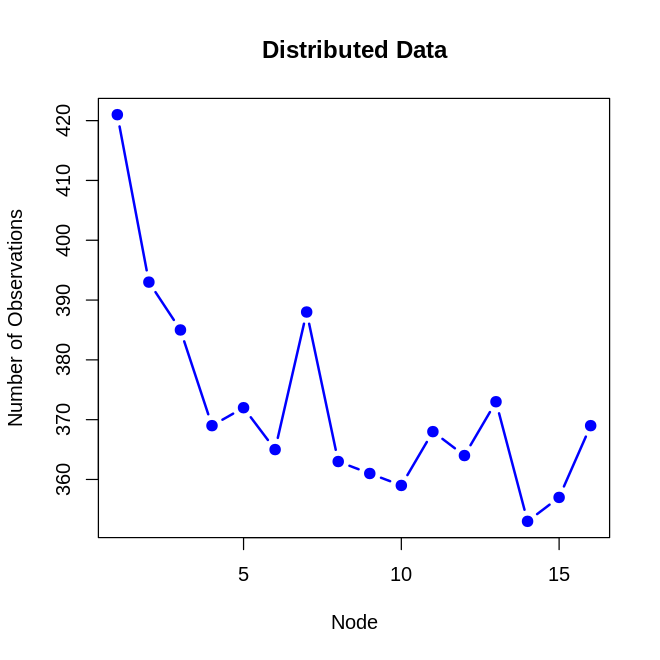

In [9]:
node_data = cas.table.tableDetails(conn,
    level = "block",
    caslib = "casuser",
    name = indata
)$TableDetails$Rows

node_data
sum(node_data)

plot(node_data, main="Distributed Data", xlab="Node", ylab='Number of Observations', col="blue", type='b', lwd=2, pch=19)

# In-Memory Data Table, CASTable Object Reference, and a casDataFrame

In [10]:
cas.table.tableInfo(conn)

NOTE: Executing action 'table.tableInfo'.
NOTE: Action 'table.tableInfo' used (Total process time):
NOTE:       real time               0.001140 seconds
NOTE:       cpu time                0.001050 seconds (92.11%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  700.59K (0.00%)


Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,...,Repeated,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
HMEQ,5960,13,0,utf-8,2020-06-17T07:26:53+00:00,2020-06-17T07:26:53+00:00,2020-06-17T07:27:07+00:00,UTF8,1907998013,...,0,0,0,,,0,viyademo01,,2020-06-17T07:26:53+00:00,1907998013


In [10]:
class(castbl)

[1] "CASTable"
attr(,"package")
[1] "swat"

In [11]:
class(head(castbl))

NOTE: Executing action 'table.fetch'.
NOTE: Action 'table.fetch' used (Total process time):
NOTE:       real time               0.002377 seconds
NOTE:       cpu time                0.002338 seconds (98.36%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  1.06M (0.00%)


[1] "casDataFrame"
attr(,"package")
[1] "swat"

# SWAT Package Functions

In [12]:
funcs = lsf.str("package:swat")
length(funcs)
head(funcs)

[1] 402

[1] "as.casDataFrame"   "as.casTable"       "assert"           
[4] "bygroupsAsColumns" "byvals"            "byvars"

In [13]:
help("as.casTable")

as.casTable {swat},R Documentation
conn,A CAS object that represents a connection and session in CAS.
df,A data.frame object with the data to upload to CAS.
casOut,"An optional character or list. If you specify a string, then the string is used as the in-memory table name. A list can be used to specify properties for the in-memory table as follows: nameAn optional character that specifies the name for the in-memory table. By default, the name of the data frame is used. caslibAn optional character that specifies the caslib. Specify this parameter to override the active caslib. labelAn optional character that specifies a descriptive label for the data. replaceAn optional logical. When set to TRUE, you can replace an existing in-memory table with the same name in the same caslib. The default value is FALSE. promoteAn optional logical. When set to TRUE, the in-memory table has global scope and can be available to other CAS sessions (subject to access controls). The default value is FALSE and the in-memory table has session scope so that it is accessible with the session that uploaded the table only. Session-scope tables are ideal for data analysis. Global-scope tables are better suited for reporting. replicationAn optional numeric that specifies the number of redundant copies of in-memory blocks. This parameter applies to distributed servers only. The default value is 1."


# Explore the Data

In [14]:
dim(castbl)
names(castbl)

NOTE: Executing action 'simple.numRows'.
NOTE: Action 'simple.numRows' used (Total process time):
NOTE:       real time               0.000791 seconds
NOTE:       cpu time                0.000750 seconds (94.82%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  441.03K (0.00%)


[1] 5960   13

[1] "BAD"     "LOAN"    "MORTDUE" "VALUE"   "REASON"  "JOB"     "YOJ"    
 [8] "DEROG"   "DELINQ"  "CLAGE"   "NINQ"    "CLNO"    "DEBTINC"

In [15]:
colMeans(castbl)
mean(castbl$BAD)

NOTE: Executing action 'table.columnInfo'.
NOTE: Action 'table.columnInfo' used (Total process time):
NOTE:       real time               0.000950 seconds
NOTE:       cpu time                0.000908 seconds (95.58%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  859.56K (0.00%)
NOTE: Executing action 'simple.summary'.
NOTE: Action 'simple.summary' used (Total process time):
NOTE:       real time               0.004410 seconds
NOTE:       cpu time                0.008340 seconds (189.12%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  2.63M (0.00%)


BAD         LOAN      MORTDUE        VALUE          YOJ        DEROG 
1.994966e-01 1.860797e+04 7.376082e+04 1.017760e+05 8.922268e+00 2.545697e-01 
      DELINQ        CLAGE         NINQ         CLNO      DEBTINC 
4.494424e-01 1.797663e+02 1.186055e+00 2.129610e+01 3.377992e+01

NOTE: Executing action 'table.columnInfo'.
NOTE: Action 'table.columnInfo' used (Total process time):
NOTE:       real time               0.000904 seconds
NOTE:       cpu time                0.000844 seconds (93.36%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  822.16K (0.00%)
NOTE: Executing action 'simple.summary'.
NOTE: Action 'simple.summary' used (Total process time):
NOTE:       real time               0.003968 seconds
NOTE:       cpu time                0.006656 seconds (167.74%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  2.57M (0.00%)


[1] 0.1994966

In [16]:
summary(castbl)

NOTE: Executing action 'table.columnInfo'.
NOTE: Action 'table.columnInfo' used (Total process time):
NOTE:       real time               0.001033 seconds
NOTE:       cpu time                0.000988 seconds (95.64%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  861.44K (0.00%)
NOTE: Executing action 'simple.distinct'.
NOTE: Action 'simple.distinct' used (Total process time):
NOTE:       real time               0.014588 seconds
NOTE:       cpu time                0.038481 seconds (263.79%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  9.60M (0.01%)
NOTE: Executing action 'simple.summary'.
NOTE: Action 'simple.summary' used (Total process time):
NOTE:       real time               0.006965 seconds
NOTE:       cpu time                0.007268 seconds (104.35%)
NOTE:       total nodes             1 (16 cores)
NOTE:       tota

      BAD              LOAN          MORTDUE           VALUE       
 Min.   :0.0000   Min.   : 1100   Min.   :  2063   Min.   :  8000  
 1st Qu.:0.0000   1st Qu.:11100   1st Qu.: 46268   1st Qu.: 66069  
 Median :0.0000   Median :16300   Median : 65019   Median : 89236  
 Mean   :0.1995   Mean   :18608   Mean   : 73761   Mean   :101776  
 3rd Qu.:0.0000   3rd Qu.:23300   3rd Qu.: 91491   3rd Qu.:119832  
 Max.   :1.0000   Max.   :89900   Max.   :399550   Max.   :855909  
                                  NA's   :   518   NA's   :   112  
     REASON          JOB            YOJ              DEROG         
 DebtCon:3928   Other  :2388   Min.   :  0.000   Min.   :  0.0000  
 HomeImp:1780   ProfExe:1276   1st Qu.:  3.000   1st Qu.:  0.0000  
 NA's   : 252   Office : 948   Median :  7.000   Median :  0.0000  
                Mgr    : 767   Mean   :  8.922   Mean   :  0.2546  
                Self   : 193   3rd Qu.: 13.000   3rd Qu.:  0.0000  
                NA's   : 279   Max.   : 41.000  

# Wrapper

In [17]:
# Head function on the castbl object
head(castbl)

# Fetch action on the server data
cas.table.fetch(conn, table=indata, to=6)

NOTE: Executing action 'table.fetch'.
NOTE: Action 'table.fetch' used (Total process time):
NOTE:       real time               0.001685 seconds
NOTE:       cpu time                0.001612 seconds (95.67%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  1.06M (0.00%)


BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
1,1100,25860,39025,HomeImp,Other,10.5,0,0,94.36667,1,9,NaN
1,1300,70053,68400,HomeImp,Other,7.0,0,2,121.83333,0,14,NaN
1,1500,13500,16700,HomeImp,Other,4.0,0,0,149.46667,1,10,NaN
1,1500,NaN,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1700,97800,112000,HomeImp,Office,3.0,0,0,93.33333,0,14,NaN
1,1700,30548,40320,HomeImp,Other,9.0,0,0,101.46600,1,8,37.11361


NOTE: Executing action 'table.fetch'.
NOTE: Action 'table.fetch' used (Total process time):
NOTE:       real time               0.001416 seconds
NOTE:       cpu time                0.001339 seconds (94.56%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  992.16K (0.00%)


_Index_,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
1,1,1100,25860,39025,HomeImp,Other,10.5,0,0,94.36667,1,9,NaN
2,1,1300,70053,68400,HomeImp,Other,7.0,0,2,121.83333,0,14,NaN
3,1,1500,13500,16700,HomeImp,Other,4.0,0,0,149.46667,1,10,NaN
4,1,1500,NaN,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0,1700,97800,112000,HomeImp,Office,3.0,0,0,93.33333,0,14,NaN
6,1,1700,30548,40320,HomeImp,Other,9.0,0,0,101.46600,1,8,37.11361


In [18]:
# nrow function on the castbl object
nrow(castbl)

# recordCount action on the server data
cas.table.recordCount(conn, table=indata)

NOTE: Executing action 'simple.numRows'.
NOTE: Action 'simple.numRows' used (Total process time):
NOTE:       real time               0.000699 seconds
NOTE:       cpu time                0.000650 seconds (92.99%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  442.53K (0.00%)


[1] 5960

NOTE: Executing action 'table.recordCount'.
NOTE: Action 'table.recordCount' used (Total process time):
NOTE:       real time               0.000668 seconds
NOTE:       cpu time                0.000619 seconds (92.66%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  516.66K (0.00%)


N
5960


# List Available Action Sets

In [19]:
listActionSets(conn)

NOTE: Executing action 'builtins.actionSetInfo'.
NOTE: Action 'builtins.actionSetInfo' used (Total process time):
NOTE:       real time               0.001177 seconds
NOTE:       cpu time                0.001119 seconds (95.07%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  628.16K (0.00%)


$actionset
 [1] "accessControl"  "accessControl"  "builtins"       "configuration" 
 [5] "dataPreprocess" "dataStep"       "percentile"     "search"        
 [9] "session"        "sessionProp"    "simple"         "table"         

$label
 [1] "Access Controls"    "Access Controls"    "Builtins"          
 [4] "Server Properties"  "Data Preprocess"    "DATA Step"         
 [7] "Percentile"         "Search"             "Session Methods"   
[10] "Session Properties" "Simple Analytics"   "Tables"            

$loaded
 [1] 1 1 1 1 1 1 1 1 1 1 1 1

$extension
 [1] "tkacon"    "casmeta"   "tkcasablt" "tkcascfg"  "tktrans"   "datastep" 
 [7] "tkcasptl"  "casidx"    "tkcsessn"  "tkcstate"  "tkimstat"  "tkcastab" 

$version
 [1] "3.05.000" "3.05.000" "3.05.000" "3.05.000" "3.05.000" "3.05.000"
 [7] "3.05.000" "3.05.000" "3.05.000" "3.05.000" "3.05.000" "3.05.000"

$product_name
 [1] "tkcas"     "tkcas"     "tkcas"     "tkcas"     "crsstat"   "tkcas"    
 [7] "crsstat"   "crssearch" "tkcas"     "tkcas"     "crsstat"   "tkcas"    

$user_defined
 [1] "false" "false" "false" "false" "false" "false" "false" "false" "false"
[10] "false" "false" "false"

attr(,".S3Class")
[1] "data.frame"
attr(,"name")
[1] "user_defined"
attr(,"label")
[1] "Action set information"
attr(,"title")
[1] ""
attr(,"attrs")
attr(,"attrs")$Action
[1] "actionSetInfo"

attr(,"attrs")$Actionset
[1] "builtins"

attr(,"attrs")$CreateTime
[1] 1907422688

attr(,"col.labels")
[1] "" "" "" "" "" "" ""
attr(,"col.formats")
[1] "" "" "" "" "" "" "" ""
attr(,"col.attrs")
list()
attr(,"col.sizes")
attr(,"col.sizes")[[1]]
[1] 1

attr(,"col.sizes")[[2]]
[1] 1

attr(,"col.sizes")[[3]]
[1] 1

attr(,"col.sizes")[[4]]
[1] 1

attr(,"col.sizes")[[5]]
[1] 1

attr(,"col.sizes")[[6]]
[1] 1

attr(,"col.sizes")[[7]]
[1] 1

attr(,"col.sizes")[[8]]
[1] 1

attr(,"col.sizes")[[9]]
[1] 1

attr(,"col.sizes")[[10]]
[1] 1

attr(,"col.sizes")[[11]]
[1] 1

attr(,"col.sizes")[[12]]
[1] 1

attr(,"col.sizes")[[13]]
[1] 1

attr(,"col.sizes")[[14]]
[1] 1

attr(,"col.types")
[1] "varchar" "varchar" "int32"   "varchar" "varchar" "varchar" "varchar"
attr(,"col.widths")
[1] 14 18  4  9  8  9  5
attr(,"df")
        actionset              label loaded extension  version product_name
1   accessControl    Access Controls      1    tkacon 3.05.000        tkcas
2   accessControl    Access Controls      1   casmeta 3.05.000        tkcas
3        builtins           Builtins      1 tkcasablt 3.05.000        tkcas
4   configuration  Server Properties      1  tkcascfg 3.05.000        tkcas
5  dataPreprocess    Data Preprocess      1   tktrans 3.05.000      crsstat
6        dataStep          DATA Step      1  datastep 3.05.000        tkcas
7      percentile         Percentile      1  tkcasptl 3.05.000      crsstat
8          search             Search      1    casidx 3.05.000    crssearch
9         session    Session Methods      1  tkcsessn 3.05.000        tkcas
10    sessionProp Session Properties      1  tkcstate 3.05.000        tkcas
11         simple   Simple Analytics      1  tkimstat 3.05.000      crsstat
12          table             Tables      1  tkcastab 3.05.000        tkcas
   user_defined
1         false
2         false
3         false
4         false
5         false
6         false
7         false
8         false
9         false
10        false
11        false
12        false

In [20]:
#http://go.documentation.sas.com/?cdcId=pgmcdc&cdcVersion=8.11&docsetId=allprodsactions&docsetTarget=actionSetsByName.htm&locale=en

# Explore the Data using CAS Actions

In [21]:
loadActionSet(conn, 'simple')

NOTE: Executing action 'builtins.loadActionSet'.
NOTE: Added action set 'simple'.
NOTE: Action 'builtins.loadActionSet' used (Total process time):
NOTE:       real time               0.000445 seconds
NOTE:       cpu time                0.000400 seconds (89.89%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  209.81K (0.00%)
NOTE: Executing action 'builtins.actionSetInfo'.
NOTE: Action 'builtins.actionSetInfo' used (Total process time):
NOTE:       real time               0.000950 seconds
NOTE:       cpu time                0.000909 seconds (95.68%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  318.25K (0.00%)
NOTE: Executing action 'builtins.listActions'.
NOTE: Information for action set 'simple':
NOTE:    simple
NOTE:       mdSummary - Calculates multidimensional summaries of numeric variables
NOTE:       numRows - Shows th

In [22]:
cas.simple.correlation(conn,
    table = indata,
    inputs = c("LOAN","VALUE","MORTDUE")
)

NOTE: Executing action 'simple.correlation'.
NOTE: Action 'simple.correlation' used (Total process time):
NOTE:       real time               0.010442 seconds
NOTE:       cpu time                0.034955 seconds (334.75%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  2.96M (0.00%)


Variable,N,Mean,Sum,StdDev,Minimum,Maximum
LOAN,5960,18607.97,110903500,11207.48,1100,89900
VALUE,5848,101776.05,595186333,57385.78,8000,855909
MORTDUE,5442,73760.82,401406367,44457.61,2063,399550
Variable,LOAN,VALUE,MORTDUE,Nobs1,Nobs2,Nobs3
LOAN,1.0000000,0.3353929,0.2285947,5960,5848,5442
VALUE,0.3353929,1.0000000,0.8756656,5848,5848,5357
MORTDUE,0.2285947,0.8756656,1.0000000,5442,5357,5442


In [23]:
cas.simple.distinct(conn,
    table = indata,
    inputs = names(castbl)
)

NOTE: Executing action 'simple.distinct'.
NOTE: Action 'simple.distinct' used (Total process time):
NOTE:       real time               0.016289 seconds
NOTE:       cpu time                0.041638 seconds (255.62%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  9.59M (0.01%)


Column,NDistinct,NMiss,Trunc
BAD,2,0,0
LOAN,540,0,0
MORTDUE,5054,518,0
VALUE,5382,112,0
REASON,3,252,0
JOB,7,279,0
YOJ,100,515,0
DEROG,12,708,0
DELINQ,15,580,0
CLAGE,5315,308,0


In [24]:
cas.simple.freq(conn,
    table = indata,
    inputs = c("BAD","JOB","REASON")
)

NOTE: Executing action 'simple.freq'.
NOTE: Action 'simple.freq' used (Total process time):
NOTE:       real time               0.006085 seconds
NOTE:       cpu time                0.013775 seconds (226.38%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  3.68M (0.00%)


Column,NumVar,CharVar,FmtVar,Level,Frequency
BAD,0,,0,1,4771
BAD,1,,1,2,1189
JOB,NaN,,,1,279
JOB,NaN,Mgr,Mgr,2,767
JOB,NaN,Office,Office,3,948
JOB,NaN,Other,Other,4,2388
JOB,NaN,ProfExe,ProfExe,5,1276
JOB,NaN,Sales,Sales,6,109
JOB,NaN,Self,Self,7,193
REASON,NaN,,,1,252


In [25]:
cas.simple.crossTab(conn,
    table = indata,
    row = "BAD", col = "JOB"
)

NOTE: Executing action 'simple.crossTab'.
NOTE: Action 'simple.crossTab' used (Total process time):
NOTE:       real time               0.004627 seconds
NOTE:       cpu time                0.010412 seconds (225.03%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  1.41M (0.00%)


BAD,Col1,Col2,Col3,Col4,Col5,Col6
0,588,823,1834,1064,71,135
1,179,125,554,212,38,58


In [26]:
loadActionSet(conn, 'cardinality')

NOTE: Executing action 'builtins.loadActionSet'.
NOTE: Added action set 'cardinality'.
NOTE: Action 'builtins.loadActionSet' used (Total process time):
NOTE:       real time               0.000953 seconds
NOTE:       cpu time                0.000882 seconds (92.55%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  210.84K (0.00%)
NOTE: Executing action 'builtins.actionSetInfo'.
NOTE: Action 'builtins.actionSetInfo' used (Total process time):
NOTE:       real time               0.001101 seconds
NOTE:       cpu time                0.001037 seconds (94.19%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  319.22K (0.00%)
NOTE: Executing action 'builtins.listActions'.
NOTE: Information for action set 'cardinality':
NOTE:    cardinality
NOTE:       summarize - Provides actions for evaluating data cardinality
NOTE: Action 'builtins.li

In [27]:
cas.cardinality.summarize(conn,
    table = indata,
    cardinality = list(name='card', replace=TRUE)
)

NOTE: Executing action 'cardinality.summarize'.
NOTE: Writing cardinality.
NOTE: status = 0.
NOTE: The Cloud Analytic Services server processed the request in 0.012064 seconds.
NOTE: Action 'cardinality.summarize' used (Total process time):
NOTE:       real time               0.012996 seconds
NOTE:       cpu time                0.056913 seconds (437.93%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  3.80M (0.00%)


list()

In [28]:
cas.table.fetch(conn, table='card', to=5)
cas.table.recordCount(conn, table='card')

NOTE: Executing action 'table.fetch'.
NOTE: Action 'table.fetch' used (Total process time):
NOTE:       real time               0.001907 seconds
NOTE:       cpu time                0.001867 seconds (97.90%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  1021.28K (0.00%)


_Index_,_VARNAME_,_FMTWIDTH_,_TYPE_,_RLEVEL_,_ORDER_,_MORE_,_CARDINALITY_,_NOBS_,_SUMFREQS_,...,_SKEWNESS_,_KURTOSIS_,_MFREQ_,_MFREQFOUNDLEVEL_,_MFREQNUM_,_MFREQCHR_,_MFREQCFMT_,_LASTNUM_,_LASTCHR_,_LASTCFMT_
1,BAD,12,N,CLASS,ASC,N,2,5960,5960,...,1.504317,0.2630568,4771,Y,0,,0,1,,1
2,LOAN,12,N,INTERVAL,ASC,Y,30,5960,5960,...,2.023781,6.9325898,5829,N,NaN,,,4700,,4700
3,MORTDUE,12,N,INTERVAL,ASC,Y,30,5960,5442,...,1.814481,6.4818663,5411,N,NaN,,,6124,,6124
4,VALUE,12,N,INTERVAL,ASC,Y,30,5960,5848,...,3.053344,24.3628049,5818,N,NaN,,,20631,,20631
5,REASON,7,C,CLASS,ASC,N,2,5960,5708,...,NaN,NaN,3928,Y,NaN,DebtCon,DebtCon,NaN,HomeImp,HomeImp


NOTE: Executing action 'table.recordCount'.
NOTE: Action 'table.recordCount' used (Total process time):
NOTE:       real time               0.000786 seconds
NOTE:       cpu time                0.000743 seconds (94.53%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  516.63K (0.00%)


N
13


# Define Cas Table

In [29]:
card = defCasTable(conn, tablename = "card")
head(card)
dim(card)

NOTE: Executing action 'table.columnInfo'.
NOTE: Action 'table.columnInfo' used (Total process time):
NOTE:       real time               0.001172 seconds
NOTE:       cpu time                0.001108 seconds (94.54%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  836.78K (0.00%)
NOTE: Executing action 'table.fetch'.
NOTE: Action 'table.fetch' used (Total process time):
NOTE:       real time               0.002475 seconds
NOTE:       cpu time                0.002416 seconds (97.62%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  1.12M (0.00%)


_VARNAME_,_FMTWIDTH_,_TYPE_,_RLEVEL_,_ORDER_,_MORE_,_CARDINALITY_,_NOBS_,_SUMFREQS_,_NMISS_,...,_SKEWNESS_,_KURTOSIS_,_MFREQ_,_MFREQFOUNDLEVEL_,_MFREQNUM_,_MFREQCHR_,_MFREQCFMT_,_LASTNUM_,_LASTCHR_,_LASTCFMT_
BAD,12,N,CLASS,ASC,N,2,5960,5960,0,...,1.504317,0.2630568,4771,Y,0,,0,1,,1
LOAN,12,N,INTERVAL,ASC,Y,30,5960,5960,0,...,2.023781,6.9325898,5829,N,NaN,,,4700,,4700
MORTDUE,12,N,INTERVAL,ASC,Y,30,5960,5442,518,...,1.814481,6.4818663,5411,N,NaN,,,6124,,6124
VALUE,12,N,INTERVAL,ASC,Y,30,5960,5848,112,...,3.053344,24.3628049,5818,N,NaN,,,20631,,20631
REASON,7,C,CLASS,ASC,N,2,5960,5708,252,...,NaN,NaN,3928,Y,NaN,DebtCon,DebtCon,NaN,HomeImp,HomeImp
JOB,7,C,CLASS,ASC,N,6,5960,5681,279,...,NaN,NaN,2388,Y,NaN,Other,Other,NaN,Self,Self


NOTE: Executing action 'simple.numRows'.
NOTE: Action 'simple.numRows' used (Total process time):
NOTE:       real time               0.001186 seconds
NOTE:       cpu time                0.001127 seconds (95.03%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  506.78K (0.00%)


[1] 13 26

# Visualize Numeric Variables Locally

In [30]:
loadActionSet(conn, 'sampling')

NOTE: Executing action 'builtins.loadActionSet'.
NOTE: Added action set 'sampling'.
NOTE: Action 'builtins.loadActionSet' used (Total process time):
NOTE:       real time               0.002892 seconds
NOTE:       cpu time                0.002844 seconds (98.34%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  215.81K (0.00%)
NOTE: Executing action 'builtins.actionSetInfo'.
NOTE: Action 'builtins.actionSetInfo' used (Total process time):
NOTE:       real time               0.001091 seconds
NOTE:       cpu time                0.001050 seconds (96.24%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  318.09K (0.00%)
NOTE: Executing action 'builtins.listActions'.
NOTE: Information for action set 'sampling':
NOTE:    sampling
NOTE:       srs -  Samples a proportion of data from the input table or partitions the data into no more th

In [31]:
cas.sampling.srs(conn,
    table   = indata,
    samppct = 50,
    seed = 12345,
    partind = FALSE,
    output  = list(casOut = list(name = 'mysam', replace = T),  copyVars = 'ALL')
)

NOTE: Executing action 'sampling.srs'.
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=12345 for sampling.
NOTE: Action 'sampling.srs' used (Total process time):
NOTE:       real time               0.016922 seconds
NOTE:       cpu time                0.026793 seconds (158.33%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  39.13M (0.03%)


$SRSFreq
  NObs NSamp
1 5960  2980

$OutputCasTables
               casLib  Name Label Rows Columns
1 CASUSER(viyademo01) mysam       2980      13

NOTE: Executing action 'table.columnInfo'.
NOTE: Action 'table.columnInfo' used (Total process time):
NOTE:       real time               0.001040 seconds
NOTE:       cpu time                0.000970 seconds (93.27%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  829.28K (0.00%)
NOTE: Executing action 'table.fetch'.
NOTE: Action 'table.fetch' used (Total process time):
NOTE:       real time               0.046426 seconds
NOTE:       cpu time                0.046382 seconds (99.91%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  1.15M (0.00%)
Warning message:
“Removed 2398 rows containing non-finite values (stat_bin).”

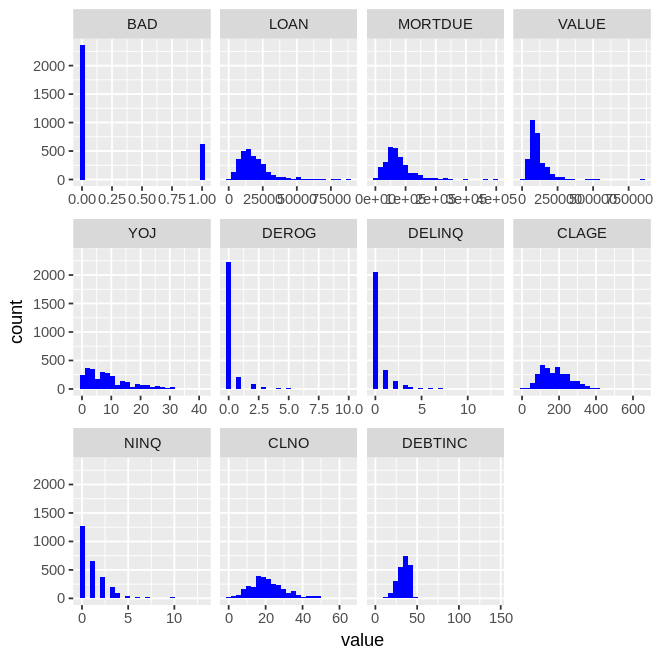

In [32]:
# Create connection object
mysam = defCasTable(conn, table='mysam')

# Bring data locally
df = to.casDataFrame(mysam)

# Use reshape2's melt to help with data formatting
df = melt(df[sapply(df, is.numeric)], id.vars=NULL)

# Plot data with ggplot
ggplot(df, aes(x = value)) +  facet_wrap(~variable,scales = 
   'free_x') + geom_histogram(fill = 'blue', bins = 25)

# Check Data for Missing Values

In [33]:
# Create a casDataFrame containing number of missing values for each variable
tbl = cas.simple.distinct(castbl)$Distinct[,c('Column', 'NMiss')]
class(tbl)
tbl

NOTE: Executing action 'simple.distinct'.
NOTE: Action 'simple.distinct' used (Total process time):
NOTE:       real time               0.016132 seconds
NOTE:       cpu time                0.043231 seconds (267.98%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  9.60M (0.01%)


[1] "data.frame"

Column,NMiss
BAD,0
LOAN,0
MORTDUE,518
VALUE,112
REASON,252
JOB,279
YOJ,515
DEROG,708
DELINQ,580
CLAGE,308


NOTE: Executing action 'simple.numRows'.
NOTE: Action 'simple.numRows' used (Total process time):
NOTE:       real time               0.000767 seconds
NOTE:       cpu time                0.000710 seconds (92.57%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  442.53K (0.00%)


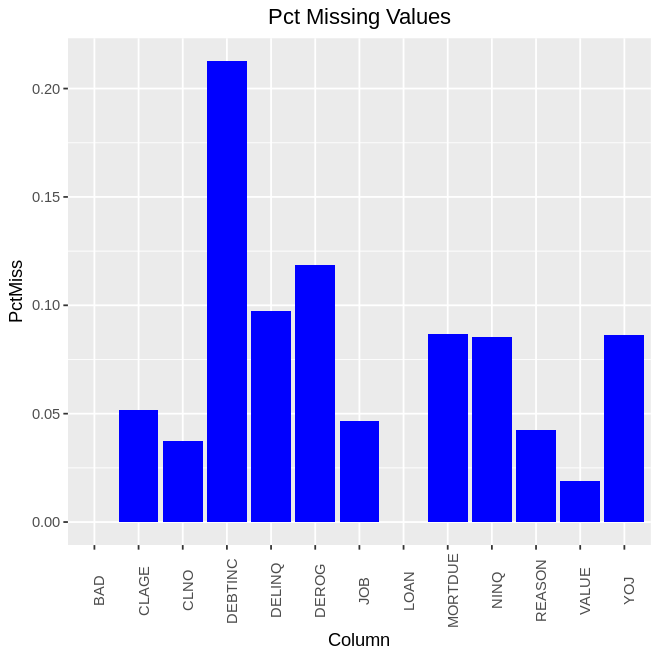

In [34]:
# Plot the percent of missing values locally
tbl$PctMiss = tbl$NMiss/nrow(castbl)
ggplot(tbl, aes(Column, PctMiss)) + geom_col(fill = 'blue') + 
   ggtitle('Pct Missing Values') + theme(plot.title = 
   element_text(hjust = 0.5), axis.text.x = element_text(angle = 90))

# Impute Missing Values

In [35]:
cas.dataPreprocess.impute(conn,
    table = indata,
    methodContinuous = 'MEDIAN',
    methodNominal    = 'MODE',
    inputs           = colnames(castbl)[-1],
    copyAllVars      = TRUE,
    casOut           = list(name = indata, replace = TRUE)
)

NOTE: Executing action 'dataPreprocess.impute'.
NOTE: Action 'dataPreprocess.impute' used (Total process time):
NOTE:       real time               0.026781 seconds
NOTE:       cpu time                0.110083 seconds (411.05%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  39.44M (0.03%)


Variable,ImputeTech,ResultVar,N,NMiss,ImputedValueContinuous,ImputedValueNominal
LOAN,Median,IMP_LOAN,5960,0,16300.00000,
MORTDUE,Median,IMP_MORTDUE,5442,518,65019.00000,
VALUE,Median,IMP_VALUE,5848,112,89235.50000,
REASON,Mode,IMP_REASON,5708,252,NaN,DebtCon
JOB,Mode,IMP_JOB,5681,279,NaN,Other
YOJ,Median,IMP_YOJ,5445,515,7.00000,
DEROG,Median,IMP_DEROG,5252,708,0.00000,
DELINQ,Median,IMP_DELINQ,5380,580,0.00000,
CLAGE,Median,IMP_CLAGE,5652,308,173.46667,
NINQ,Median,IMP_NINQ,5450,510,1.00000,


# Create Variable Shortcuts

In [36]:
# Get variable info and types
colinfo = cas.table.columnInfo(conn, table=indata)$ColumnInfo
colinfo

NOTE: Executing action 'table.columnInfo'.
NOTE: Action 'table.columnInfo' used (Total process time):
NOTE:       real time               0.001032 seconds
NOTE:       cpu time                0.000995 seconds (96.41%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  836.69K (0.00%)


Column,Label,ID,Type,RawLength,FormattedLength,Format,NFL,NFD
BAD,,1,double,8,12,,0,0
LOAN,,2,double,8,12,,0,0
MORTDUE,,3,double,8,12,,0,0
VALUE,,4,double,8,12,,0,0
REASON,,5,varchar,7,7,,0,0
JOB,,6,varchar,7,7,,0,0
YOJ,,7,double,8,12,,0,0
DEROG,,8,double,8,12,,0,0
DELINQ,,9,double,8,12,,0,0
CLAGE,,10,double,8,12,,0,0


In [37]:
# Target variable is the first variable
target = colinfo$Column[1]

# Get all variables
inputs = colinfo$Column[-1]
nominals = c(target, subset(colinfo, Type == 'varchar')$Column)

# Get only imputed variables
inputs = grep('IMP_', inputs, value = T)
nominals = c(target, grep('IMP_', nominals, value = T))

target
inputs
nominals

[1] "BAD"

[1] "IMP_CLAGE"   "IMP_CLNO"    "IMP_DEBTINC" "IMP_DELINQ"  "IMP_DEROG"  
 [6] "IMP_LOAN"    "IMP_MORTDUE" "IMP_NINQ"    "IMP_VALUE"   "IMP_YOJ"    
[11] "IMP_JOB"     "IMP_REASON"

[1] "BAD"        "IMP_JOB"    "IMP_REASON"

# R Machine Learning Demo - Part ll

# Split the Data into Training and Validation

In [38]:
cas.sampling.srs(conn,
    table   = indata,
    samppct = 70,
    seed = 919,
    partind = TRUE,
    output  = list(casOut = list(name = indata, replace = T),  copyVars = 'ALL')
)

NOTE: Executing action 'sampling.srs'.
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=919 for sampling.
NOTE: Action 'sampling.srs' used (Total process time):
NOTE:       real time               0.017335 seconds
NOTE:       cpu time                0.033409 seconds (192.73%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  40.72M (0.03%)


$SRSFreq
  NObs NSamp
1 5960  4172

$OutputCasTables
               casLib Name Label Rows Columns
1 CASUSER(viyademo01) hmeq       5960      26

# View the partition

In [39]:
loadActionSet(conn, 'fedSql')

NOTE: Executing action 'builtins.loadActionSet'.
NOTE: Added action set 'fedSql'.
NOTE: Action 'builtins.loadActionSet' used (Total process time):
NOTE:       real time               0.001935 seconds
NOTE:       cpu time                0.001864 seconds (96.33%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  247.22K (0.00%)
NOTE: Executing action 'builtins.actionSetInfo'.
NOTE: Action 'builtins.actionSetInfo' used (Total process time):
NOTE:       real time               0.001045 seconds
NOTE:       cpu time                0.001002 seconds (95.89%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  319.56K (0.00%)
NOTE: Executing action 'builtins.listActions'.
NOTE: Information for action set 'fedSql':
NOTE:    fedSql
NOTE:       execDirect - Submits a SAS FedSQL language statement for immediate execution
NOTE: Action 'builtins.l

In [40]:
# Make sure the partition worked correctly using SQL
counts = cas.fedSql.execDirect(conn, query =
    "
    SELECT _PartInd_, count(*) 
    FROM hmeq 
    GROUP BY _PartInd_;
    "
)$`Result Set`

counts
counts$Percent = counts$COUNT/sum(counts$COUNT)
counts

NOTE: Executing action 'fedSql.execDirect'.
NOTE: Action 'fedSql.execDirect' used (Total process time):
NOTE:       real time               0.053356 seconds
NOTE:       cpu time                0.174736 seconds (327.49%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  66.58M (0.05%)


_PartInd_,COUNT
0,1788
1,4172


_PartInd_,COUNT,Percent
0,1788,0.3
1,4172,0.7


In [41]:
# Refresh the castbl object
castbl = defCasTable(conn, table=indata)

# Make sure the partition worked correctly using R code
mean(castbl$`_PartInd_`)

NOTE: Executing action 'table.columnInfo'.
NOTE: Action 'table.columnInfo' used (Total process time):
NOTE:       real time               0.000911 seconds
NOTE:       cpu time                0.000875 seconds (96.05%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  837.41K (0.00%)
NOTE: Executing action 'table.columnInfo'.
NOTE: Action 'table.columnInfo' used (Total process time):
NOTE:       real time               0.000750 seconds
NOTE:       cpu time                0.000709 seconds (94.53%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  829.16K (0.00%)
NOTE: Executing action 'simple.summary'.
NOTE: Action 'simple.summary' used (Total process time):
NOTE:       real time               0.004445 seconds
NOTE:       cpu time                0.008202 seconds (184.52%)
NOTE:       total nodes             1 (16 cores)
NOTE:       t

[1] 0.7

# Dimension Reduction - Var Reduce

In [42]:
loadActionSet(conn, 'varReduce')

NOTE: Executing action 'builtins.loadActionSet'.
NOTE: Added action set 'varReduce'.
NOTE: Action 'builtins.loadActionSet' used (Total process time):
NOTE:       real time               0.001359 seconds
NOTE:       cpu time                0.001297 seconds (95.44%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  210.78K (0.00%)
NOTE: Executing action 'builtins.actionSetInfo'.
NOTE: Action 'builtins.actionSetInfo' used (Total process time):
NOTE:       real time               0.000993 seconds
NOTE:       cpu time                0.000916 seconds (92.25%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  319.25K (0.00%)
NOTE: Executing action 'builtins.listActions'.
NOTE: Information for action set 'varReduce':
NOTE:    varReduce
NOTE:       unsuper - Provides an action for performing unsupervised dimension reduction
NOTE:       sup

In [43]:
varReduce_obj = cas.varReduce.super(conn,
    table = indata,
    target = target,
    inputs = inputs,
    nominals = nominals,
    varexp = 0.90
)

names(varReduce_obj)

NOTE: Executing action 'varReduce.super'.
NOTE: Action 'varReduce.super' used (Total process time):
NOTE:       real time               0.017199 seconds
NOTE:       cpu time                0.048843 seconds (283.99%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  3.05M (0.00%)


[1] "Nobs"             "SelectionSummary" "SelectedEffects"

In [44]:
varReduce_obj$SelectionSummary

Iteration,Variable,Parameter,VarExp,SSE,MSE,AIC,AICC,BIC
1,IMP_DELINQ,IMP_DELINQ,0.1200645,1.759871,0.0002953299,0.5669184,2.566919,0.5666990
2,IMP_DEROG,IMP_DEROG,0.1657445,1.668511,0.0002800455,0.5142806,2.514283,0.5148487
3,IMP_CLAGE,IMP_CLAGE,0.1904379,1.619124,0.0002718019,0.4849055,2.484909,0.4862610
4,IMP_DEBTINC,IMP_DEBTINC,0.2070668,1.585866,0.0002662637,0.4648222,2.464826,0.4669650
5,IMP_NINQ,IMP_NINQ,0.2155122,1.568976,0.0002634720,0.4547853,2.454791,0.4577156
6,IMP_LOAN,IMP_LOAN,0.2201275,1.559745,0.0002619659,0.4495559,2.449563,0.4532735
7,IMP_JOB,IMP_JOB Office,0.2242440,1.551512,0.0002606269,0.4449346,2.444944,0.4494396
8,IMP_CLNO,IMP_CLNO,0.2275932,1.544814,0.0002595453,0.4412791,2.441291,0.4465715
9,IMP_JOB,IMP_JOB Sales,0.2297767,1.540447,0.0002588551,0.4391194,2.439134,0.4451991
10,IMP_REASON,IMP_REASON DebtCon,0.2321058,1.535788,0.0002581157,0.4367620,2.436779,0.4436291


In [45]:
varReduce_obj$SelectedEffects
varReduce_obj$SelectedEffects$Variable

Number,Variable,Type
1,IMP_DELINQ,INTERVAL
2,IMP_DEROG,INTERVAL
3,IMP_CLAGE,INTERVAL
4,IMP_DEBTINC,INTERVAL
5,IMP_NINQ,INTERVAL
6,IMP_LOAN,INTERVAL
7,IMP_JOB,CLASS
8,IMP_CLNO,INTERVAL
9,IMP_REASON,CLASS
10,IMP_MORTDUE,INTERVAL


[1] "IMP_DELINQ"  "IMP_DEROG"   "IMP_CLAGE"   "IMP_DEBTINC" "IMP_NINQ"   
 [6] "IMP_LOAN"    "IMP_JOB"     "IMP_CLNO"    "IMP_REASON"  "IMP_MORTDUE"
[11] "IMP_VALUE"   "IMP_YOJ"

# Logistic Regression

In [46]:
loadActionSet(conn, 'regression')

NOTE: Executing action 'builtins.loadActionSet'.
NOTE: Added action set 'regression'.
NOTE: Action 'builtins.loadActionSet' used (Total process time):
NOTE:       real time               0.003419 seconds
NOTE:       cpu time                0.003362 seconds (98.33%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  229.03K (0.00%)
NOTE: Executing action 'builtins.actionSetInfo'.
NOTE: Action 'builtins.actionSetInfo' used (Total process time):
NOTE:       real time               0.001213 seconds
NOTE:       cpu time                0.001160 seconds (95.63%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  315.59K (0.00%)
NOTE: Executing action 'builtins.listActions'.
NOTE: Information for action set 'regression':
NOTE:    regression
NOTE:       glm - Fits linear regression models using the method of least squares
NOTE:       genmod 

In [47]:
cas.regression.logistic(conn,
    table    = list(name = indata, where = '_PartInd_ = 1'),
    classVars = nominals[-1],
    model = list(depvar=target, effects=inputs, dist='binomial', link='logit'),
    store    = list(name='lr_model', replace=TRUE)
)

NOTE: Executing action 'regression.logistic'.
NOTE: Convergence criterion (GCONV=1E-8) satisfied.
NOTE: 458231 bytes were written to the table "lr_model" in the caslib "CASUSER(viyademo01)".
NOTE: Action 'regression.logistic' used (Total process time):
NOTE:       real time               0.032116 seconds
NOTE:       cpu time                0.080136 seconds (249.52%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  9.92M (0.01%)


$ModelInfo
     RowId                Description                       Value
1     DATA                Data Source                        HMEQ
2 EVENTVAR Response Variable (Events)                         BAD
3     DIST               Distribution                    Binomial
4     LINK              Link Function                       Logit
5     TECH     Optimization Technique Newton-Raphson with Ridging

$NObs
  RowId                 Description Value
1 NREAD Number of Observations Read  4172
2 NUSED Number of Observations Used  4172

$ResponseProfile
  OrderedValue  Outcome Freq Modeled
1            1    Event  837       *
2            2 Nonevent 3335        

$ClassInfo
       Class Levels                              Values
1    IMP_JOB      6 Mgr Office Other ProfExe Sales Self
2 IMP_REASON      2                     DebtCon HomeImp

$ConvergenceStatus
                                         Reason Status  MaxGradient Separation
1 Convergence criterion (GCONV=1E-8) satisfied.      0 2.464589e-09         -3

$Dimensions
        RowId                Description Value
1 NDESIGNCOLS          Columns in Design    19
2    NEFFECTS          Number of Effects    13
3   MAXEFCOLS         Max Effect Columns     6
4  DESIGNRANK             Rank of Design    17
5     OPTPARM Parameters in Optimization    17

$GlobalTest
              Test DF    ChiSq     ProbChiSq
1 Likelihood Ratio 16 992.1735 5.307617e-201

$FitStatistics
  RowId              Description    Value
1  M2LL        -2 Log Likelihood 3190.383
2   AIC  AIC (smaller is better) 3224.383
3  AICC AICC (smaller is better) 3224.530
4   SBC  SBC (smaller is better) 3332.098

$ParameterEstimates
        Effect IMP_JOB IMP_REASON          Parameter           ParmName DF
1    Intercept                             Intercept          Intercept  1
2    IMP_CLAGE                             IMP_CLAGE          IMP_CLAGE  1
3     IMP_CLNO                              IMP_CLNO           IMP_CLNO  1
4  IMP_DEBTINC                           IMP_DEBTINC        IMP_DEBTINC  1
5   IMP_DELINQ                            IMP_DELINQ         IMP_DELINQ  1
6    IMP_DEROG                             IMP_DEROG          IMP_DEROG  1
7     IMP_LOAN                              IMP_LOAN           IMP_LOAN  1
8  IMP_MORTDUE                           IMP_MORTDUE        IMP_MORTDUE  1
9     IMP_NINQ                              IMP_NINQ           IMP_NINQ  1
10   IMP_VALUE                             IMP_VALUE          IMP_VALUE  1
11     IMP_YOJ                               IMP_YOJ            IMP_YOJ  1
12     IMP_JOB     Mgr                   IMP_JOB Mgr        IMP_JOB_Mgr  1
13     IMP_JOB  Office                IMP_JOB Office     IMP_JOB_Office  1
14     IMP_JOB   Other                 IMP_JOB Other      IMP_JOB_Other  1
15     IMP_JOB ProfExe               IMP_JOB ProfExe    IMP_JOB_ProfExe  1
16     IMP_JOB   Sales                 IMP_JOB Sales      IMP_JOB_Sales  1
17     IMP_JOB    Self                  IMP_JOB Self       IMP_JOB_Self  0
18  IMP_REASON            DebtCon IMP_REASON DebtCon IMP_REASON_DebtCon  1
19  IMP_REASON            HomeImp IMP_REASON HomeImp IMP_REASON_HomeImp  0
        Estimate       StdErr       ChiSq    ProbChiSq
1  -2.011370e+00 3.705041e-01  29.4712015 5.675377e-08
2  -5.154343e-03 6.508736e-04  62.7123715 2.392084e-15
3  -2.029034e-02 5.244300e-03  14.9693730 1.092704e-04
4   6.887911e-02 7.814006e-03  77.7011714 1.198702e-18
5   7.827495e-01 4.668851e-02 281.0772003 4.373782e-63
6   6.337265e-01 6.064999e-02 109.1798192 1.482115e-25
7  -2.339415e-05 5.027908e-06  21.6491082 3.273622e-06
8  -4.587379e-06 1.657052e-06   7.6640288 5.633257e-03
9   1.716768e-01 2.482519e-02  47.8231090 4.664613e-12
10  3.844999e-06 1.123954e-06  11.7029539 6.240096e-04
11 -8.625194e-03 6.858641e-03   1.5814724 2.085487e-01
12 -5.642188e-01 2.567348e-01   4.8297600 2.797252e-02
13 -1.186029e+00 2.609072e-01  20.6641851 5.473020e-06
14 -6.200069e-01 2.366462e-01   6.8642660 8.793636e-03
15 

# Support Vector Machine

In [48]:
loadActionSet(conn, 'svm')

NOTE: Executing action 'builtins.loadActionSet'.
NOTE: Added action set 'svm'.
NOTE: Action 'builtins.loadActionSet' used (Total process time):
NOTE:       real time               0.001671 seconds
NOTE:       cpu time                0.001625 seconds (97.25%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  217.16K (0.00%)
NOTE: Executing action 'builtins.actionSetInfo'.
NOTE: Action 'builtins.actionSetInfo' used (Total process time):
NOTE:       real time               0.001120 seconds
NOTE:       cpu time                0.001081 seconds (96.52%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  314.97K (0.00%)
NOTE: Executing action 'builtins.listActions'.
NOTE: Information for action set 'svm':
NOTE:    svm
NOTE:       svmTrain - Provides actions for support vector machines
NOTE: Action 'builtins.listActions' used (Total proces

In [49]:
cas.svm.svmTrain(conn,
    table    = list(name = indata, where = '_PartInd_ = 1'),
    target   = target, 
    inputs   = inputs, 
    nominals = nominals,
    kernel = 'polynomial', 
    degree = 2,
    savestate = list(name = 'svm_model', replace = TRUE)
)

NOTE: Executing action 'svm.svmTrain'.
NOTE: SVM training is activated.
NOTE: 10049 bytes were written to the table "svm_model" in the caslib "CASUSER(viyademo01)".
NOTE: Action 'svm.svmTrain' used (Total process time):
NOTE:       real time               1.075437 seconds
NOTE:       cpu time                0.723334 seconds (67.26%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  36.32M (0.03%)


$ModelInfo
          RowId                  Descr          Value  NValue
1      TaskType              Task Type         C_CLAS     NaN
2        Method Optimization Technique Interior Point     NaN
3         Scale                  Scale            YES     NaN
4        Kernel        Kernel Function     Polynomial     NaN
5        degree          Kernel Degree              2 2.0e+00
6 PenaltyMethod         Penalty Method              C     NaN
7             C      Penalty Parameter              1 1.0e+00
8       MaxIter     Maximum Iterations             25 2.5e+01
9     Tolerance              Tolerance          1e-06 1.0e-06

$NObs
                        Descr    N
1 Number of Observations Read 4172
2 Number of Observations Used 4172

$TrainingResult
         RowId                               Descr       Value
1           WW            Inner Product of Weights   91.142909
2         Beta                                Bias   -1.055889
3   TotalSlack Total Slack (Constraint Violations) 1362.032452
4   LongVector              Norm of Longest Vector    4.938278
5     nSupport           Number of Support Vectors 1517.000000
6  nSupportInM Number of Support Vectors on Margin 1394.000000
7     MaximumF                           Maximum F   10.134366
8     MinimumF                           Minimum F   -3.296393
9     nEffects                   Number of Effects   12.000000
10     nLevels              Columns in Data Matrix   18.000000
11  MatrixSize            Columns in Kernel Matrix  190.000000

$IterHistory
   Iteration Complementarity  Feasibility
1          1    1.002230e+06 2.587067e+06
2          2    1.345852e+03 2.187190e+03
3          3    1.744975e+02 2.187189e-05
4          4    1.767397e+01 2.166960e-06
5          5    2.337110e+00 4.386289e-08
6          6    1.377408e+00 2.117631e-08
7          7    2.955464e-01 2.587254e-09
8          8    1.913260e-01 1.348773e-09
9          9    8.620853e-02 4.654302e-10
10        10    6.511836e-02 2.917211e-10
11        11    4.163721e-02 1.638253e-10
12        12    3.252841e-02 1.067806e-10
13        13    2.033091e-02 5.249440e-11
14        14    1.289273e-02 2.813882e-11
15        15    9.796992e-03 1.871292e-11
16        16    5.111702e-03 7.917972e-12
17        17    2.854622e-03 3.242101e-12
18        18    1.153621e-03 6.857015e-13
19        19    5.605516e-04 2.049039e-13
20        20    6.393923e-05 3.311240e-14
21        21    1.242144e-05 9.006684e-14
22        22    7.103464e-07 3.961276e-13

$Misclassification
  Observed PredEvent PredNonEvent TotalTrain
1        0      3295           40       3335
2        1       578          259        837
3    Total      3873          299       4172

$FitStatistics
    Statistic  Training
1    Accuracy 0.8518696
2       Error 0.1481304
3 Sensitivity 0.9880060
4 Specificity 0.3094385

# Decision Tree

In [50]:
loadActionSet(conn, 'decisionTree')

NOTE: Executing action 'builtins.loadActionSet'.
NOTE: Added action set 'decisionTree'.
NOTE: Action 'builtins.loadActionSet' used (Total process time):
NOTE:       real time               0.002612 seconds
NOTE:       cpu time                0.002534 seconds (97.01%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  225.91K (0.00%)
NOTE: Executing action 'builtins.actionSetInfo'.
NOTE: Action 'builtins.actionSetInfo' used (Total process time):
NOTE:       real time               0.001079 seconds
NOTE:       cpu time                0.001037 seconds (96.11%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  323.19K (0.00%)
NOTE: Executing action 'builtins.listActions'.
NOTE: Information for action set 'decisionTree':
NOTE:    decisionTree
NOTE:       dtreeTrain - Trains a decision tree
NOTE:       dtreeScore - Scores a table using a

In [51]:
cas.decisionTree.dtreeTrain(conn,
    table    = list(name = indata, where = '_PartInd_ = 1'),
    target   = target, 
    inputs   = inputs, 
    nominals = nominals,
    casOut   = list(name = 'dt_model', replace = TRUE)
)

NOTE: Executing action 'decisionTree.dtreeTrain'.
NOTE: Action 'decisionTree.dtreeTrain' used (Total process time):
NOTE:       real time               0.091005 seconds
NOTE:       cpu time                0.214325 seconds (235.51%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  66.05M (0.05%)


Descr,Value
Number of Tree Nodes,37.00000
Max Number of Branches,2.00000
Number of Levels,6.00000
Number of Leaves,19.00000
Number of Bins,50.00000
Minimum Size of Leaves,5.00000
Maximum Size of Leaves,3756.00000
Number of Variables,12.00000
Confidence Level for Pruning,0.25000
Number of Observations Used,4172.00000


# Random Forest

In [52]:
cas.decisionTree.forestTrain(conn,
    table    = list(name = indata, where = '_PartInd_ = 1'),
    target   = target, 
    inputs   = inputs, 
    nominals = nominals,
    nTree    = 1000,
    casOut   = list(name = 'rf_model', replace = TRUE)
)

NOTE: Executing action 'decisionTree.forestTrain'.
NOTE: Action 'decisionTree.forestTrain' used (Total process time):
NOTE:       real time               1.846518 seconds
NOTE:       cpu time                15.018357 seconds (813.33%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  505.34M (0.40%)


Descr,Value
Number of Trees,1000.00000
Number of Selected Variables (M),4.00000
Random Number Seed,0.00000
Bootstrap Percentage (%),63.21206
Number of Bins,50.00000
Number of Variables,12.00000
Confidence Level for Pruning,0.25000
Max Number of Tree Nodes,45.00000
Min Number of Tree Nodes,25.00000
Max Number of Branches,2.00000


# Gradient Boosting

In [53]:
cas.decisionTree.gbtreeTrain(conn,
    table    = list(name = indata, where = '_PartInd_ = 1'),
    target   = target, 
    inputs   = inputs, 
    nominals = nominals,
    nTree    = 1000,
    casOut   = list(name = 'gbt_model', replace = TRUE)
)

NOTE: Executing action 'decisionTree.gbtreeTrain'.
NOTE: Action 'decisionTree.gbtreeTrain' used (Total process time):
NOTE:       real time               12.683287 seconds
NOTE:       cpu time                58.559656 seconds (461.71%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  98.68M (0.08%)


Descr,Value
Number of Trees,1000.000
Distribution,2.000
Learning Rate,0.100
Subsampling Rate,0.500
Number of Selected Variables (M),12.000
Number of Bins,50.000
Number of Variables,12.000
Max Number of Tree Nodes,31.000
Min Number of Tree Nodes,17.000
Max Number of Branches,2.000


# Neural Network

In [54]:
loadActionSet(conn, 'neuralNet')

NOTE: Executing action 'builtins.loadActionSet'.
NOTE: Added action set 'neuralNet'.
NOTE: Action 'builtins.loadActionSet' used (Total process time):
NOTE:       real time               0.002113 seconds
NOTE:       cpu time                0.002056 seconds (97.30%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  212.78K (0.00%)
NOTE: Executing action 'builtins.actionSetInfo'.
NOTE: Action 'builtins.actionSetInfo' used (Total process time):
NOTE:       real time               0.001176 seconds
NOTE:       cpu time                0.001122 seconds (95.41%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  317.91K (0.00%)
NOTE: Executing action 'builtins.listActions'.
NOTE: Information for action set 'neuralNet':
NOTE:    neuralNet
NOTE:       annTrain - Trains an artificial neural network
NOTE:       annScore - Scores a table using a

In [55]:
cas.neuralNet.annTrain(conn,
    table    = list(name = indata, where = '_PartInd_ = 1'),
    target   = target, 
    inputs   = inputs, 
    nominals = nominals,
    hiddens = list(150),
    nloOpts    = list(optmlOpt = list(maxIters = 100, 
                      fConv = 1e-10),
                      lbfgsOpt = list(numCorrections = 6)),
    casOut   = list(name = 'nn_model', replace = TRUE)
)

NOTE: Executing action 'neuralNet.annTrain'.
NOTE: Action 'neuralNet.annTrain' used (Total process time):
NOTE:       real time               2.459843 seconds
NOTE:       cpu time                18.958691 seconds (770.73%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  10.93M (0.01%)


Progress,Objective,Loss,FitError
1,5.1957311,5.1957311,0.61888782
2,2.0148861,2.0148861,0.19319271
3,1.7268908,1.7268908,0.17857143
4,1.5935140,1.5935140,0.16754554
5,1.5699056,1.5699056,0.16538830
6,1.5411322,1.5411322,0.16347076
7,1.5165488,1.5165488,0.16107383
8,1.4810119,1.4810119,0.15604027
9,1.4566923,1.4566923,0.14813039
10,1.4252495,1.4252495,0.14525407


# Score the Models

In [56]:
loadActionSet(conn, 'aStore')

NOTE: Executing action 'builtins.loadActionSet'.
NOTE: Added action set 'aStore'.
NOTE: Action 'builtins.loadActionSet' used (Total process time):
NOTE:       real time               0.001331 seconds
NOTE:       cpu time                0.001277 seconds (95.94%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  210.78K (0.00%)
NOTE: Executing action 'builtins.actionSetInfo'.
NOTE: Action 'builtins.actionSetInfo' used (Total process time):
NOTE:       real time               0.001119 seconds
NOTE:       cpu time                0.001070 seconds (95.62%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  316.34K (0.00%)
NOTE: Executing action 'builtins.listActions'.
NOTE: Information for action set 'astore':
NOTE:    astore
NOTE:       download - Downloads a remote store to a local store
NOTE:       upload - Uploads a local store to a 

In [57]:
#Score the support vector machine model
cas.astore.score(conn,
    table    = list(name = indata, where = '_PartInd_ = 0'),
    rstore = "svm_model",
    out = list(name="svm_scored", replace=TRUE)
)

NOTE: Executing action 'astore.score'.
NOTE: Action 'astore.score' used (Total process time):
NOTE:       real time               0.009334 seconds
NOTE:       cpu time                0.021324 seconds (228.46%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  37.63M (0.03%)


$OutputCasTables
               casLib       Name Rows Columns
1 CASUSER(viyademo01) svm_scored 1788       5

$Timing
                Task      Seconds    Percent
1  Loading the Store 8.511543e-05 0.01201858
2 Creating the State 2.883911e-03 0.40721788
3            Scoring 3.854990e-03 0.54433746
4              Total 7.081985e-03 1.00000000

In [58]:
#Score the logistic regression model
lr_score_obj = cas.regression.logisticScore(conn,
    table    = list(name = indata, where = '_PartInd_ = 0'),
    restore = "lr_model",
    casout = list(name="lr_scored", replace=TRUE),
    copyVars = list(target)
)

#Score the decision tree model
dt_score_obj = cas.decisionTree.dtreeScore(conn,
    table    = list(name = indata, where = '_PartInd_ = 0'),
    model = "dt_model",
    casout = list(name="dt_scored",replace=TRUE),
    copyVars = list(target),
    encodename = TRUE,
    assessonerow = TRUE
)

#Score the random forest model
rf_score_obj = cas.decisionTree.forestScore(conn,
    table    = list(name = indata, where = '_PartInd_ = 0'),
    model = "rf_model",
    casout = list(name="rf_scored",replace=TRUE),
    copyVars = list(target),
    encodename = TRUE,
    assessonerow = TRUE
)

#Score the gradient boosting model
gb_score_obj = cas.decisionTree.gbtreeScore(conn,
    table    = list(name = indata, where = '_PartInd_ = 0'),
    model = "gbt_model",
    casout = list(name="gbt_scored",replace=TRUE),
    copyVars = list(target),
    encodename = TRUE,
    assessonerow = TRUE
)

#Score the neural network model
nn_score_obj = cas.neuralNet.annScore(conn,
    table    = list(name = indata, where = '_PartInd_ = 0'),
    model = "nn_model",
    casout = list(name="nn_scored",replace=TRUE),
    copyVars = list(target),
    encodename = TRUE,
    assessonerow = TRUE
)

NOTE: Executing action 'regression.logisticScore'.
NOTE: Action 'regression.logisticScore' used (Total process time):
NOTE:       real time               0.012301 seconds
NOTE:       cpu time                0.022946 seconds (186.54%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  21.39M (0.02%)
NOTE: Executing action 'decisionTree.dtreeScore'.
NOTE: Action 'decisionTree.dtreeScore' used (Total process time):
NOTE:       real time               0.010164 seconds
NOTE:       cpu time                0.018312 seconds (180.17%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  34.98M (0.03%)
NOTE: Executing action 'decisionTree.forestScore'.
NOTE: Action 'decisionTree.forestScore' used (Total process time):
NOTE:       real time               0.305933 seconds
NOTE:       cpu time                1.848239 seconds (604.13%)
NOTE:       

In [59]:
#View selected fields from the output object
nn_score_obj$OutputCasTables
nn_score_obj$ScoreInfo

casLib,Name,Rows,Columns
CASUSER(viyademo01),nn_scored,1788,4


Descr,Value
Number of Observations Read,1788
Number of Observations Used,1788
Misclassification Error (%),8.2214765101


# Assess the Models

In [60]:
loadActionSet(conn, 'percentile')

NOTE: Executing action 'builtins.loadActionSet'.
NOTE: Added action set 'percentile'.
NOTE: Action 'builtins.loadActionSet' used (Total process time):
NOTE:       real time               0.000457 seconds
NOTE:       cpu time                0.000390 seconds (85.34%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  209.78K (0.00%)
NOTE: Executing action 'builtins.actionSetInfo'.
NOTE: Action 'builtins.actionSetInfo' used (Total process time):
NOTE:       real time               0.000960 seconds
NOTE:       cpu time                0.000930 seconds (96.88%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  315.34K (0.00%)
NOTE: Executing action 'builtins.listActions'.
NOTE: Information for action set 'percentile':
NOTE:    percentile
NOTE:       percentile - Calculate quantiles and percentiles
NOTE:       boxPlot - Calculate quantile

In [61]:
# Change the name of the prediction variable for logistic regression
cas.dataStep.runCode(conn, code="
    data lr_scored;
        set lr_scored;
        rename _PRED_ = P_BAD1;
    run;
"
)

# Add the target variable to the svm scored table
cas.dataStep.runCode(conn, code="
    data svm_scored;
        merge svm_scored(keep=P_BAD1) lr_scored(keep=BAD);
    run;
"
)

NOTE: Executing action 'dataStep.runCode'.
NOTE: Action 'dataStep.runCode' used (Total process time):
NOTE:       real time               0.018386 seconds
NOTE:       cpu time                0.053166 seconds (289.17%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  5.71M (0.00%)


$InputCasTables
               casLib      Name Rows Columns
1 CASUSER(viyademo01) lr_scored 1788       2

$OutputCasTables
               casLib      Name Rows Columns Append Promoted
1 CASUSER(viyademo01) lr_scored 1788       2    NaN        N

NOTE: Executing action 'dataStep.runCode'.
NOTE: Action 'dataStep.runCode' used (Total process time):
NOTE:       real time               0.023347 seconds
NOTE:       cpu time                0.068970 seconds (295.41%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  5.30M (0.00%)


$InputCasTables
               casLib       Name Rows Columns
1 CASUSER(viyademo01) svm_scored 1788       5
2 CASUSER(viyademo01)  lr_scored 1788       2

$OutputCasTables
               casLib       Name Rows Columns Append Promoted
1 CASUSER(viyademo01) svm_scored 1788       2    NaN        N

In [62]:
# Create prediction variable name
assess_input = paste("P_", target, "1", sep = "")

# Assess the logistic regression model
lr_assess_obj = cas.percentile.assess(conn,
   table = 'lr_scored',
   inputs = assess_input,
   casout = list(name="lr_assess",replace=TRUE),
   response = target,
   event = "1"
)

# Assess the support vector machine model
svm_assess_obj = cas.percentile.assess(conn,
   table = 'svm_scored',
   inputs = assess_input,
   casout = list(name="svm_assess",replace=TRUE),
   response = target,
   event = "1"
)

# Assess the decision tree model
dt_assess_obj = cas.percentile.assess(conn,
   table = "dt_scored",
   inputs = assess_input,
   casout = list(name="dt_assess",replace=TRUE),
   response = target,
   event = "1"
)

# Assess the random forest model
rf_assess_obj = cas.percentile.assess(conn,
   table = "rf_scored",
   inputs = assess_input,
   casout = list(name="rf_assess",replace=TRUE),
   response = target,
   event = "1"
)

#Assess the gradient boosting model
gb_assess_obj = cas.percentile.assess(conn,
   table = "gbt_scored",
   inputs = assess_input,
   casout = list(name="gbt_assess",replace=TRUE),
   response = target,
   event = "1"
)

# Assess the neural network model
nn_assess_obj = cas.percentile.assess(conn,
   table = "nn_scored",
   inputs = assess_input,
   casout = list(name="nn_assess",replace=TRUE),
   response = target,
   event = "1"
)

NOTE: Executing action 'percentile.assess'.
NOTE: Action 'percentile.assess' used (Total process time):
NOTE:       real time               0.008047 seconds
NOTE:       cpu time                0.021140 seconds (262.71%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  6.56M (0.01%)
NOTE: Executing action 'percentile.assess'.
NOTE: Action 'percentile.assess' used (Total process time):
NOTE:       real time               0.006499 seconds
NOTE:       cpu time                0.016812 seconds (258.69%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  6.51M (0.01%)
NOTE: Executing action 'percentile.assess'.
NOTE: Action 'percentile.assess' used (Total process time):
NOTE:       real time               0.004999 seconds
NOTE:       cpu time                0.011067 seconds (221.38%)
NOTE:       total nodes             1 (16 cores)
NOTE:

In [63]:
nn_assess_obj$OutputCasTables

casLib,Name,Rows,Columns
CASUSER(viyademo01),nn_assess,20,21
CASUSER(viyademo01),nn_assess_ROC,100,21


# View the Assess Action Output

In [64]:
cas.table.fetch(conn, table='nn_assess', to=5)
cas.table.fetch(conn, table='nn_assess_ROC', to=5)

NOTE: Executing action 'table.fetch'.
NOTE: Action 'table.fetch' used (Total process time):
NOTE:       real time               0.001555 seconds
NOTE:       cpu time                0.001520 seconds (97.75%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  1003.88K (0.00%)


_Index_,_Column_,_Event_,_Depth_,_Value_,_NObs_,_NEvents_,_NEventsBest_,_Resp_,_RespBest_,...,_CumResp_,_CumRespBest_,_CumLift_,_CumLiftBest_,_PctResp_,_PctRespBest_,_CumPctResp_,_CumPctRespBest_,_Gain_,_GainBest_
1,P_BAD1,1,5,0.999994808,90,90,90,25.568182,25.56818,...,25.56818,25.56818,5.113636,5.113636,100.00000,100.00000,100.00000,100.00000,4.113636,4.113636
2,P_BAD1,1,10,0.987861119,90,82,90,23.295455,25.56818,...,48.86364,51.13636,4.886364,5.113636,91.11111,100.00000,95.55556,100.00000,3.886364,4.113636
3,P_BAD1,1,15,0.445359851,90,64,90,18.181818,25.56818,...,67.04545,76.70455,4.469697,5.113636,71.11111,100.00000,87.40741,100.00000,3.469697,4.113636
4,P_BAD1,1,20,0.051519809,90,38,82,10.795455,23.29545,...,77.84091,100.00000,3.892045,5.000000,42.22222,91.11111,76.11111,97.77778,2.892045,4.000000
5,P_BAD1,1,25,0.007953124,90,12,0,3.409091,0.00000,...,81.25000,100.00000,3.250000,4.000000,13.33333,0.00000,63.55556,78.22222,2.250000,3.000000


NOTE: Executing action 'table.fetch'.
NOTE: Action 'table.fetch' used (Total process time):
NOTE:       real time               0.001627 seconds
NOTE:       cpu time                0.001597 seconds (98.16%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  995.63K (0.00%)


_Index_,_Column_,_Event_,_Cutoff_,_TP_,_FP_,_FN_,_TN_,_Sensitivity_,_Specificity_,...,_FHALF_,_FPR_,_ACC_,_FDR_,_F1_,_C_,_GINI_,_GAMMA_,_TAU_,_MiscEvent_
1,P_BAD1,1,0.00,352,1436,0,0,1.0000000,0.0000000,...,0.2345416,1.00000000,0.1968680,0.8031320,0.3289720,0.8870452,0.7740904,0.9338204,0.2449214,0.80313199
2,P_BAD1,1,0.01,286,147,66,1289,0.8125000,0.8976323,...,0.6861804,0.10236769,0.8808725,0.3394919,0.7286624,0.8870452,0.7740904,0.9338204,0.2449214,0.11912752
3,P_BAD1,1,0.02,280,114,72,1322,0.7954545,0.9206128,...,0.7261411,0.07938719,0.8959732,0.2893401,0.7506702,0.8870452,0.7740904,0.9338204,0.2449214,0.10402685
4,P_BAD1,1,0.03,278,98,74,1338,0.7897727,0.9317549,...,0.7489224,0.06824513,0.9038031,0.2606383,0.7637363,0.8870452,0.7740904,0.9338204,0.2449214,0.09619687
5,P_BAD1,1,0.04,278,90,74,1346,0.7897727,0.9373259,...,0.7620614,0.06267409,0.9082774,0.2445652,0.7722222,0.8870452,0.7740904,0.9338204,0.2449214,0.09172260


# Bring Results to the Client

In [65]:
# Create table objects from the assess output, 
# bring data to the client, 
# and add new variable to data frame indicating model name

lr_assess_ROC = defCasTable(conn, tablename = "lr_assess_ROC")
lr_assess_ROC = to.casDataFrame(lr_assess_ROC)
lr_assess_ROC$Model = 'Logistic Regression'

svm_assess_ROC = defCasTable(conn, tablename = "svm_assess_ROC")
svm_assess_ROC = to.casDataFrame(svm_assess_ROC)
svm_assess_ROC$Model = 'Support Vector Machine'

dt_assess_ROC = defCasTable(conn, tablename = "dt_assess_ROC")
dt_assess_ROC = to.casDataFrame(dt_assess_ROC)
dt_assess_ROC$Model = 'Decision Tree'

rf_assess_ROC = defCasTable(conn, tablename = "rf_assess_ROC")
rf_assess_ROC = to.casDataFrame(rf_assess_ROC)
rf_assess_ROC$Model = 'Random Forest'

gbt_assess_ROC = defCasTable(conn, tablename = "gbt_assess_ROC")
gbt_assess_ROC = to.casDataFrame(gbt_assess_ROC)
gbt_assess_ROC$Model = 'Gradient Boosting'

nn_assess_ROC = defCasTable(conn, tablename = "nn_assess_ROC")
nn_assess_ROC = to.casDataFrame(nn_assess_ROC)
nn_assess_ROC$Model = 'Neural Network'

NOTE: Executing action 'table.columnInfo'.
NOTE: Action 'table.columnInfo' used (Total process time):
NOTE:       real time               0.001078 seconds
NOTE:       cpu time                0.001036 seconds (96.10%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  863.63K (0.00%)
NOTE: Executing action 'table.fetch'.
NOTE: Action 'table.fetch' used (Total process time):
NOTE:       real time               0.004408 seconds
NOTE:       cpu time                0.004341 seconds (98.48%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  1.11M (0.00%)
NOTE: Executing action 'table.columnInfo'.
NOTE: Action 'table.columnInfo' used (Total process time):
NOTE:       real time               0.001195 seconds
NOTE:       cpu time                0.001137 seconds (95.15%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memo

# Compare Confusion Matrix

In [66]:
df_assess = rbind(lr_assess_ROC, svm_assess_ROC, dt_assess_ROC, rf_assess_ROC, gbt_assess_ROC, nn_assess_ROC)
cutoff_index = round(df_assess[,3],2)==0.5
compare = df_assess[cutoff_index,]
rownames(compare) = NULL
compare[,c('Model','_TP_','_FP_','_FN_','_TN_')]

Model,_TP_,_FP_,_FN_,_TN_
Logistic Regression,108,47,244,1389
Support Vector Machine,97,14,255,1422
Decision Tree,99,42,253,1394
Random Forest,93,15,259,1421
Gradient Boosting,250,35,102,1401
Neural Network,235,30,117,1406


# Compare Misclassification

In [67]:
compare$Misclassification = 1 - compare$'_ACC_'
miss = compare[order(compare$Misclassification), c('Model','Misclassification')]
rownames(miss) = NULL
miss

Model,Misclassification
Gradient Boosting,0.07662192
Neural Network,0.08221477
Support Vector Machine,0.15044743
Random Forest,0.15324385
Logistic Regression,0.16275168
Decision Tree,0.16498881


# Compare ROC Curves

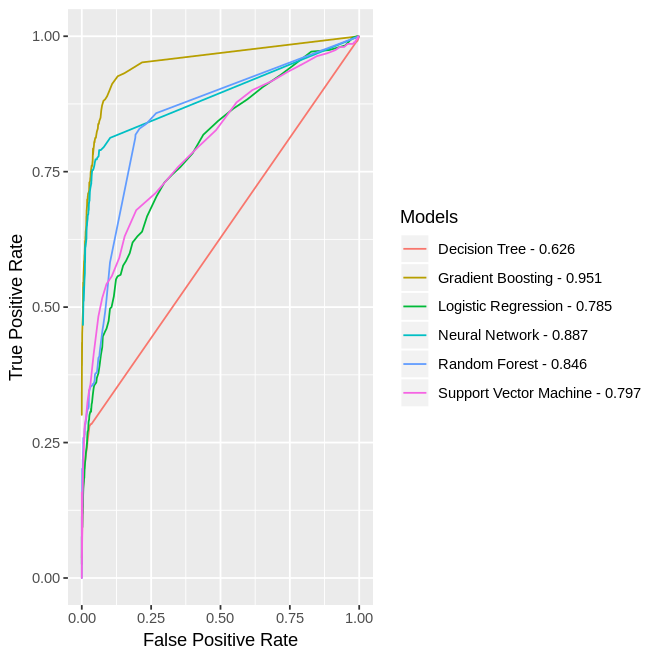

In [68]:
# Add a new column to be used as the ROC curve label
df_assess$Models = paste(df_assess$Model, round(df_assess$'_C_', 3), sep = ' - ')

#Subset the data frame with only three variables 
df_roc = df_assess[c('_FPR_', '_Sensitivity_', 'Models')]
colnames(df_roc) = c("FPR", "Sensitivity", "Models")

# Create the ROC curve
ggplot(data = df_roc, 
   aes(x = FPR, y = Sensitivity, colour = Models)) + 
   geom_line() +
   labs(x = 'False Positive Rate', y = 'True Positive Rate')

# Compare Lift Curves

In [69]:
lr_assess_lift = defCasTable(conn, tablename = "lr_assess")
lr_assess_lift = to.casDataFrame(lr_assess_lift)
lr_assess_lift$Model = 'Logistic Regression'

svm_assess_lift = defCasTable(conn, tablename = "svm_assess")
svm_assess_lift = to.casDataFrame(svm_assess_lift)
svm_assess_lift$Model = 'Support Vector Machine'

dt_assess_lift = defCasTable(conn, tablename = "dt_assess")
dt_assess_lift = to.casDataFrame(dt_assess_lift)
dt_assess_lift$Model = 'Decision Tree'

rf_assess_lift = defCasTable(conn, tablename = "rf_assess")
rf_assess_lift = to.casDataFrame(rf_assess_lift)
rf_assess_lift$Model = 'Random Forest'

gbt_assess_lift = defCasTable(conn, tablename = "gbt_assess")
gbt_assess_lift = to.casDataFrame(gbt_assess_lift)
gbt_assess_lift$Model = 'Gradient Boosting'

nn_assess_lift = defCasTable(conn, tablename = "nn_assess")
nn_assess_lift = to.casDataFrame(nn_assess_lift)
nn_assess_lift$Model = 'Neural Network'

df_assess = rbind(lr_assess_lift, svm_assess_lift, dt_assess_lift, rf_assess_lift, gbt_assess_lift, nn_assess_lift)

NOTE: Executing action 'table.columnInfo'.
NOTE: Action 'table.columnInfo' used (Total process time):
NOTE:       real time               0.001241 seconds
NOTE:       cpu time                0.001186 seconds (95.57%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  863.63K (0.00%)
NOTE: Executing action 'table.fetch'.
NOTE: Action 'table.fetch' used (Total process time):
NOTE:       real time               0.003079 seconds
NOTE:       cpu time                0.003028 seconds (98.34%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  1.12M (0.00%)
NOTE: Executing action 'table.columnInfo'.
NOTE: Action 'table.columnInfo' used (Total process time):
NOTE:       real time               0.001112 seconds
NOTE:       cpu time                0.001054 seconds (94.78%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memo

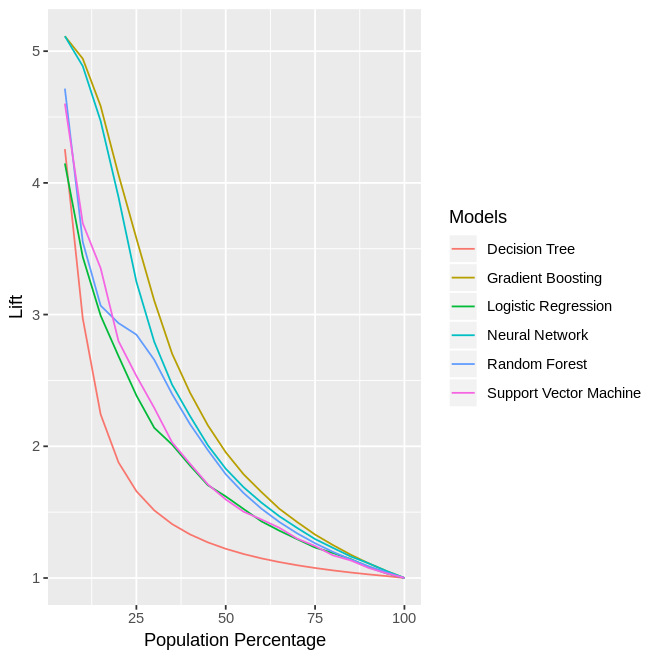

In [70]:
df_lift = df_assess[c('_Depth_', '_CumLift_', 'Model')]
colnames(df_lift) = c("Depth", "CumLift", "Models")

ggplot(data = df_lift, 
   aes(x = Depth, y = CumLift, colour = Models)) + 
   geom_line() +
   labs(x = 'Population Percentage', y = 'Lift')

# Fit an XGBoost Model in R Locally

In [71]:
# Create sample to bring to the client
cas.sampling.srs(conn,
    table   = indata,
    samppct = 75,
    seed = 12345,
    partind = FALSE,
    output  = list(casOut = list(name = 'mysam', replace = T),  copyVars = 'ALL')
)

NOTE: Executing action 'sampling.srs'.
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=12345 for sampling.
NOTE: Action 'sampling.srs' used (Total process time):
NOTE:       real time               0.019829 seconds
NOTE:       cpu time                0.030675 seconds (154.70%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  40.77M (0.03%)


$SRSFreq
  NObs NSamp
1 5960  4470

$OutputCasTables
               casLib  Name Label Rows Columns
1 CASUSER(viyademo01) mysam       4470      26

In [72]:
# Bring data locally
mysam = defCasTable(conn, table='mysam')
df = to.casDataFrame(mysam)
df = df[,c(target, inputs, '_PartInd_')]

# Create dummy variables through one-hot encoding
df.dum = df[,nominals[-1]]
dummies = dummyVars('~ .', data = df.dum)
df.ohe = as.data.frame(predict(dummies, newdata = df))
df.all.combined = cbind(df[,-c(which(colnames(df) %in% 
   nominals[-1]))], df.ohe)

# Split into training and validation
train = df.all.combined[df.all.combined['_PartInd_'] == 1,]
valid = df.all.combined[df.all.combined['_PartInd_'] == 0,]

# Train the XGBoost model
set.seed(101112)
bst = xgboost(
    data = data.matrix(train[,-1]),
    label = data.matrix(train[,1]),
    nround = 25,
    objective = "binary:logistic",
    eta = 0.1,
    max_depth = 5,  
    subsample = 0.5,
    colsample_bytree = 0.5
)

NOTE: Executing action 'table.columnInfo'.
NOTE: Action 'table.columnInfo' used (Total process time):
NOTE:       real time               0.000969 seconds
NOTE:       cpu time                0.000922 seconds (95.15%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  864.25K (0.00%)
NOTE: Executing action 'table.fetch'.
NOTE: Action 'table.fetch' used (Total process time):
NOTE:       real time               0.104564 seconds
NOTE:       cpu time                0.104502 seconds (99.94%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  1.33M (0.00%)


[1]	train-error:0.111821 
[2]	train-error:0.129712 
[3]	train-error:0.147604 
[4]	train-error:0.137061 
[5]	train-error:0.128115 
[6]	train-error:0.138019 
[7]	train-error:0.119489 
[8]	train-error:0.121725 
[9]	train-error:0.128115 
[10]	train-error:0.114058 
[11]	train-error:0.115974 
[12]	train-error:0.119169 
[13]	train-error:0.117252 
[14]	train-error:0.119169 
[15]	train-error:0.109585 
[16]	train-error:0.112141 
[17]	train-error:0.105431 
[18]	train-error:0.102875 
[19]	train-error:0.100000 
[20]	train-error:0.099681 
[21]	train-error:0.101278 
[22]	train-error:0.099042 
[23]	train-error:0.094249 
[24]	train-error:0.093930 
[25]	train-error:0.091054 


# Score and Assess XGBoost on Validation Data

In [73]:
pred = as.numeric(predict(bst, data.matrix(valid[,-1]), missing = 'NAN') > 0.5)
Misclassification = mean(as.numeric(pred > 0.5) != valid[,1])
xgb = data.frame(cbind(Model = 'R - XGBoost', Misclassification))
xgb

Model,Misclassification
R - XGBoost,0.114925373134328


# Final Assessment with CAS and R Models

In [74]:
# Combine the assessments and order by most accurate on validation data
err = data.frame(rbind(miss, xgb))
err[,-1] = round(as.numeric(as.character(err[,-1])),7)
err = err[order(err[,-1]),]
rownames(err) = NULL
err

Model,Misclassification
Gradient Boosting,0.0766219
Neural Network,0.0822148
R - XGBoost,0.1149254
Support Vector Machine,0.1504474
Random Forest,0.1532438
Logistic Regression,0.1627517
Decision Tree,0.1649888


# View All Data Tables in Current Session

In [75]:
cas.table.tableInfo(conn)$TableInfo[,1:3]

NOTE: Executing action 'table.tableInfo'.
NOTE: Action 'table.tableInfo' used (Total process time):
NOTE:       real time               0.001459 seconds
NOTE:       cpu time                0.001347 seconds (92.32%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  756.00K (0.00%)


Name,Rows,Columns
CARD,13,26
HMEQ,5960,26
LR_MODEL,1,2
SVM_MODEL,1,2
DT_MODEL,37,36
RF_MODEL,33372,40
GBT_MODEL,29318,30
NN_MODEL,2852,15
DT_SCORED,1788,13
RF_SCORED,1788,6


# Add caslib to specify a data source

In [76]:
# Show the current location
cas.table.caslibInfo(conn, active=FALSE, caslib="casuser")

NOTE: Executing action 'table.caslibInfo'.
NOTE: Action 'table.caslibInfo' used (Total process time):
NOTE:       real time               0.000723 seconds
NOTE:       cpu time                0.000682 seconds (94.33%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  723.59K (0.00%)


Name,Type,Description,Path,Definition,Subdirs,Local,Active,Personal,Hidden,Transient
CASUSER(viyademo01),PATH,Personal File System Caslib,/home/viyademo01/casuser/,,1,0,1,1,0,1


In [77]:
# Add CAS library named mycl
cas.table.addCaslib(conn, name="mycl", path=Sys.getenv("HOME"), dataSource="PATH", activeOnAdd = FALSE)

NOTE: Executing action 'table.addCaslib'.
NOTE: Cloud Analytic Services added the caslib 'mycl'.
NOTE: Action 'table.addCaslib' used (Total process time):
NOTE:       real time               0.000986 seconds
NOTE:       cpu time                0.000948 seconds (96.15%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  777.44K (0.00%)


Name,Type,Description,Path,Definition,Subdirs,Local,Active,Personal,Hidden,Transient
mycl,PATH,,/home/viyademo01/,,0,1,0,0,0,0


In [78]:
# Show the current location
cas.table.caslibInfo(conn)

NOTE: Executing action 'table.caslibInfo'.
NOTE: Action 'table.caslibInfo' used (Total process time):
NOTE:       real time               0.000967 seconds
NOTE:       cpu time                0.000925 seconds (95.66%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  733.22K (0.00%)


Name,Type,Description,Path,Definition,Subdirs,Local,Active,Personal,Hidden,Transient
CASUSER(viyademo01),PATH,Personal File System Caslib,/home/viyademo01/casuser/,,1,0,1,1,0,1
ddc_data,PATH,,/opt/demo/ddc/,,0,0,0,0,0,0
DNFS,DNFS,,/data/dnfs/,,1,0,0,0,0,0
Formats,PATH,Stores user defined formats.,/opt/sas/viya/config/data/cas/default/formats/,,0,0,0,0,0,0
ModelPerformanceData,PATH,Library for Model Management performance objects.,/opt/sas/viya/config/data/cas/default/modelMonitorLibrary/,,0,0,0,0,0,0
Models,PATH,Stores models created by Visual Analytics for use in other analytics or SAS Studio.,/opt/sas/viya/config/data/cas/default/models/,,0,0,0,0,0,0
Public,PATH,"Shared and writeable caslib, accessible to all users.",/opt/sas/viya/config/data/cas/default/public/,,0,0,0,0,0,0
Samples,PATH,"Stores sample data, supplied by SAS.",/opt/sas/viya/config/data/cas/default/samples/,,0,0,0,0,0,0
SQLSRV,sqlserver,,,uid = 'sqlserver',0,0,0,0,0,0
SystemData,PATH,"Stores application generated data, used for general reporting.",/opt/sas/viya/config/data/cas/default/sysData/,,0,0,0,0,0,0


# Save the Best Model

In [79]:
cas.table.save(conn, caslib = 'mycl', table = list(name = 'gbt_model'), name = 'best_model_gbt', replace = T)

NOTE: Executing action 'table.save'.
NOTE: Cloud Analytic Services saved the file best_model_gbt.sashdat in caslib mycl.
NOTE: Action 'table.save' used (Total process time):
NOTE:       real time               0.032366 seconds
NOTE:       cpu time                0.016392 seconds (50.65%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  16.57M (0.01%)


$caslib
[1] "mycl"

$name
[1] "best_model_gbt.sashdat"

In [80]:
# Save the Model Attributes
cas.table.attribute(conn, caslib = 'CASUSER', table = 'gbt_model_attr', name = 'gbt_model', task='convert')
cas.table.save(conn, caslib = 'mycl', table = 'gbt_model_attr', name = 'attr', replace = T)

NOTE: Executing action 'table.attribute'.
NOTE: Action 'table.attribute' used (Total process time):
NOTE:       real time               0.000993 seconds
NOTE:       cpu time                0.000914 seconds (92.04%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  1.36M (0.00%)


list()

NOTE: Executing action 'table.save'.
NOTE: Cloud Analytic Services saved the file attr.sashdat in caslib mycl.
NOTE: Action 'table.save' used (Total process time):
NOTE:       real time               0.003557 seconds
NOTE:       cpu time                0.001875 seconds (52.71%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  16.53M (0.01%)


$caslib
[1] "mycl"

$name
[1] "attr.sashdat"

# Drop a CASLIB

In [81]:
cas.table.dropCaslib(conn, caslib="mycl")

NOTE: Executing action 'table.dropCaslib'.
NOTE: Cloud Analytic Services removed the caslib 'mycl'.
NOTE: Action 'table.dropCaslib' used (Total process time):
NOTE:       real time               0.000528 seconds
NOTE:       cpu time                0.000489 seconds (92.61%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  291.19K (0.00%)


list()

# Promote Data Table to Global Scope

In [82]:
cas.table.promote(conn, caslib="casuser", name=indata)
cas.table.tableInfo(conn)

NOTE: Executing action 'table.promote'.
NOTE: Cloud Analytic Services promoted table HMEQ in caslib CASUSER(viyademo01) to table hmeq in caslib CASUSER(viyademo01).
NOTE: Action 'table.promote' used (Total process time):
NOTE:       real time               0.003266 seconds
NOTE:       cpu time                0.003053 seconds (93.48%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  337.09K (0.00%)


list()

NOTE: Executing action 'table.tableInfo'.
NOTE: Action 'table.tableInfo' used (Total process time):
NOTE:       real time               0.001584 seconds
NOTE:       cpu time                0.001357 seconds (85.67%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  777.16K (0.00%)


Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,...,Repeated,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
CARD,13,26,0,utf-8,2020-06-10T15:38:09+00:00,2020-06-10T15:38:09+00:00,2020-06-10T15:38:09+00:00,UTF8,1907422689,...,0,0,0,,,0,viyademo01,,,NaN
LR_MODEL,1,2,0,utf-8,2020-06-10T15:38:18+00:00,2020-06-10T15:38:18+00:00,2020-06-10T15:38:37+00:00,UTF8,1907422698,...,0,0,0,,,0,viyademo01,,,NaN
SVM_MODEL,1,2,0,utf-8,2020-06-10T15:38:19+00:00,2020-06-10T15:38:19+00:00,2020-06-10T15:38:37+00:00,UTF8,1907422699,...,0,0,0,,,0,viyademo01,,,NaN
DT_MODEL,37,36,0,utf-8,2020-06-10T15:38:20+00:00,2020-06-10T15:38:20+00:00,2020-06-10T15:38:38+00:00,UTF8,1907422700,...,0,0,0,,,0,viyademo01,,,NaN
RF_MODEL,33372,40,0,utf-8,2020-06-10T15:38:22+00:00,2020-06-10T15:38:22+00:00,2020-06-10T15:38:38+00:00,UTF8,1907422702,...,0,0,0,,,0,viyademo01,,,NaN
GBT_MODEL,29318,30,0,utf-8,2020-06-10T15:38:34+00:00,2020-06-10T15:38:34+00:00,2020-06-10T15:39:05+00:00,UTF8,1907422714,...,0,0,0,,,0,viyademo01,,,NaN
NN_MODEL,2852,15,0,utf-8,2020-06-10T15:38:37+00:00,2020-06-10T15:38:37+00:00,2020-06-10T15:38:39+00:00,UTF8,1907422717,...,0,0,0,,,0,viyademo01,,,NaN
DT_SCORED,1788,13,0,utf-8,2020-06-10T15:38:38+00:00,2020-06-10T15:38:38+00:00,2020-06-10T15:38:39+00:00,UTF8,1907422718,...,0,0,0,,,0,viyademo01,,,NaN
RF_SCORED,1788,6,0,utf-8,2020-06-10T15:38:38+00:00,2020-06-10T15:38:38+00:00,2020-06-10T15:38:39+00:00,UTF8,1907422718,...,0,0,0,,,0,viyademo01,,,NaN
GBT_SCORED,1788,5,0,utf-8,2020-06-10T15:38:38+00:00,2020-06-10T15:38:38+00:00,2020-06-10T15:38:39+00:00,UTF8,1907422718,...,0,0,0,,,0,viyademo01,,,NaN


# End the Session

In [83]:
cas.session.endSession(conn)

NOTE: Executing action 'session.endSession'.
NOTE: Action 'session.endSession' used (Total process time):
NOTE:       real time               0.000324 seconds
NOTE:       cpu time                0.000299 seconds (92.28%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  210.78K (0.00%)


list()

# R Machine Learning Demo - Part lll

![title](sas_viya_logo.png)

# R Machine Learning Demo - Part lV

In [84]:
conn <- CAS('frasepviya35smp', 5570)
# Activate metric tracing and other session parameters
cas.sessionProp.setSessOpt(conn, metrics=TRUE, timeout=1800, caslib='casuser')

NOTE: Connecting to CAS and generating CAS action functions for loaded
      action sets...
NOTE: To generate the functions with signatures (for tab completion), set 
      options(cas.gen.function.sig=TRUE).
NOTE: 'CASUSER(viyademo01)' is now the active caslib.
NOTE: Action 'sessionProp.setSessOpt' used (Total process time):
NOTE:       real time               0.003552 seconds
NOTE:       cpu time                0.003511 seconds (98.85%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  400.81K (0.00%)


list()

In [85]:
cas.table.tableInfo(conn)

NOTE: Executing action 'table.tableInfo'.
NOTE: Action 'table.tableInfo' used (Total process time):
NOTE:       real time               0.001665 seconds
NOTE:       cpu time                0.001475 seconds (88.59%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  751.31K (0.00%)


Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,...,Repeated,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
HMEQ,5960,26,0,utf-8,2020-06-10T15:38:17+00:00,2020-06-10T15:39:05+00:00,2020-06-10T15:39:05+00:00,UTF8,1907422697,...,0,0,0,,,0,viyademo01,,,NaN


In [86]:
indata = 'hmeq'
cas.table.fetch(conn, table=indata, to=6)

NOTE: Executing action 'table.fetch'.
NOTE: Action 'table.fetch' used (Total process time):
NOTE:       real time               0.003196 seconds
NOTE:       cpu time                0.003063 seconds (95.84%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  1.34M (0.00%)


_Index_,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,...,IMP_DELINQ,IMP_DEROG,IMP_LOAN,IMP_MORTDUE,IMP_NINQ,IMP_VALUE,IMP_YOJ,IMP_JOB,IMP_REASON,_PartInd_
1,1,1100,25860,39025,HomeImp,Other,10.5,0,0,...,0,0,1100,25860,1,39025.0,10.5,Other,HomeImp,0
2,1,1300,70053,68400,HomeImp,Other,7.0,0,2,...,2,0,1300,70053,0,68400.0,7.0,Other,HomeImp,0
3,1,1500,13500,16700,HomeImp,Other,4.0,0,0,...,0,0,1500,13500,1,16700.0,4.0,Other,HomeImp,0
4,1,1500,NaN,NaN,,,NaN,NaN,NaN,...,0,0,1500,65019,1,89235.5,7.0,Other,DebtCon,0
5,0,1700,97800,112000,HomeImp,Office,3.0,0,0,...,0,0,1700,97800,0,112000.0,3.0,Office,HomeImp,1
6,1,1700,30548,40320,HomeImp,Other,9.0,0,0,...,0,0,1700,30548,1,40320.0,9.0,Other,HomeImp,0


In [87]:
# Get variable info and types
colinfo = cas.table.columnInfo(conn, table=indata)$ColumnInfo

# Target variable is the first column
target = colinfo$Column[1]

# Get all variables
inputs = colinfo$Column[-1]
nominals = c(target, subset(colinfo, Type == 'varchar')$Column)

# Get only imputed variables
inputs = grep('IMP_', inputs, value = T)
nominals = c(target, grep('IMP_', nominals, value = T))

target
inputs
nominals

NOTE: Executing action 'table.columnInfo'.
NOTE: Action 'table.columnInfo' used (Total process time):
NOTE:       real time               0.001184 seconds
NOTE:       cpu time                0.001073 seconds (90.63%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  828.72K (0.00%)


[1] "BAD"

[1] "IMP_CLAGE"   "IMP_CLNO"    "IMP_DEBTINC" "IMP_DELINQ"  "IMP_DEROG"  
 [6] "IMP_LOAN"    "IMP_MORTDUE" "IMP_NINQ"    "IMP_VALUE"   "IMP_YOJ"    
[11] "IMP_JOB"     "IMP_REASON"

[1] "BAD"        "IMP_JOB"    "IMP_REASON"

# Load a Saved Table into Memory

In [88]:
# Create a CASLIB
cas.table.addCaslib(conn, name="mycl", path=Sys.getenv("HOME"), dataSource="PATH", activeOnAdd = FALSE)

# Load table and table attributes into memory
cas.table.loadTable(conn, caslib = 'mycl', path="best_model_gbt.sashdat", casOut=list(name="gbt_model", replace=TRUE))
cas.table.loadTable(conn, caslib = 'mycl', path="attr.sashdat", casOut=list(name="gbt_model_attr", replace=TRUE))
cas.table.attribute(conn, caslib='casuser', task='add', name='gbt_model', attrtable='gbt_model_attr')

cas.table.tableInfo(conn)

NOTE: Executing action 'table.addCaslib'.
NOTE: Cloud Analytic Services added the caslib 'mycl'.
NOTE: Action 'table.addCaslib' used (Total process time):
NOTE:       real time               0.001080 seconds
NOTE:       cpu time                0.001033 seconds (95.65%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  749.09K (0.00%)


Name,Type,Description,Path,Definition,Subdirs,Local,Active,Personal,Hidden,Transient
mycl,PATH,,/home/viyademo01/,,0,1,0,0,0,0


NOTE: Executing action 'table.loadTable'.
NOTE: Cloud Analytic Services made the file best_model_gbt.sashdat available as table GBT_MODEL in caslib CASUSER(viyademo01).
NOTE: Action 'table.loadTable' used (Total process time):
NOTE:       real time               0.001413 seconds
NOTE:       cpu time                0.001291 seconds (91.37%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  729.03K (0.00%)


$caslib
[1] "CASUSER(viyademo01)"

$tableName
[1] "GBT_MODEL"

NOTE: Executing action 'table.loadTable'.
NOTE: Cloud Analytic Services made the file attr.sashdat available as table GBT_MODEL_ATTR in caslib CASUSER(viyademo01).
NOTE: Action 'table.loadTable' used (Total process time):
NOTE:       real time               0.001059 seconds
NOTE:       cpu time                0.000966 seconds (91.22%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  724.38K (0.00%)


$caslib
[1] "CASUSER(viyademo01)"

$tableName
[1] "GBT_MODEL_ATTR"

NOTE: Executing action 'table.attribute'.
NOTE: Action 'table.attribute' used (Total process time):
NOTE:       real time               0.010154 seconds
NOTE:       cpu time                0.010108 seconds (99.55%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  902.47K (0.00%)


list()

NOTE: Executing action 'table.tableInfo'.
NOTE: Action 'table.tableInfo' used (Total process time):
NOTE:       real time               0.001598 seconds
NOTE:       cpu time                0.001394 seconds (87.23%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  741.09K (0.00%)


Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,...,Repeated,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
GBT_MODEL,29318,30,0,utf-8,2020-06-10T15:39:07+00:00,2020-06-10T15:39:07+00:00,2020-06-10T15:39:07+00:00,UTF8,1907422747,...,0,0,0,best_model_gbt.sashdat,mycl,0,viyademo01,,2020-06-10T15:39:05+00:00,1907422745
GBT_MODEL_ATTR,1,2,0,utf-8,2020-06-10T15:39:07+00:00,2020-06-10T15:39:07+00:00,2020-06-10T15:39:07+00:00,UTF8,1907422747,...,0,0,0,attr.sashdat,mycl,0,viyademo01,,2020-06-10T15:39:05+00:00,1907422745
HMEQ,5960,26,0,utf-8,2020-06-10T15:38:17+00:00,2020-06-10T15:39:05+00:00,2020-06-10T15:39:07+00:00,UTF8,1907422697,...,0,0,0,,,0,viyademo01,,,NaN


# Model Tuning

In [89]:
loadActionSet(conn, 'autotune')

NOTE: Executing action 'builtins.loadActionSet'.
NOTE: Added action set 'autotune'.
NOTE: Action 'builtins.loadActionSet' used (Total process time):
NOTE:       real time               0.001439 seconds
NOTE:       cpu time                0.001383 seconds (96.11%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  229.69K (0.00%)
NOTE: Executing action 'builtins.actionSetInfo'.
NOTE: Action 'builtins.actionSetInfo' used (Total process time):
NOTE:       real time               0.001107 seconds
NOTE:       cpu time                0.001079 seconds (97.47%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  314.66K (0.00%)
NOTE: Executing action 'builtins.listActions'.
NOTE: Information for action set 'autotune':
NOTE:    autotune
NOTE:       tuneSvm - Automatically adjusts support vector machine parameters to tune a model for minimum e

# Forest Tuning

In [90]:
cas.autotune.tuneForest(conn,
    trainOptions = list(
        table    = list(name = indata, where = '_PartInd_ = 1'),
        target   = target, 
        inputs   = inputs, 
        nominals = nominals,
        casOut   = list(name = 'rf_tune_model', replace = TRUE) ) ,
    tunerOptions = list(seed = 802, maxEvals = 10, maxTime = 30)
)

NOTE: Executing action 'autotune.tuneForest'.
NOTE: Autotune is started for 'Forest' model.
NOTE: Autotune option SEARCHMETHOD='GA'.
NOTE: Autotune option MAXEVALS=10.
NOTE: Autotune option MAXTIME=30 (sec.).
NOTE: Autotune option SEED=802.
NOTE: Autotune objective is 'Misclassification Error Percentage'.
NOTE: Autotune number of parallel evaluations is set to 4, each using 0 worker nodes.
NOTE: Executing action 'builtins.loadActionSet'.
NOTE: Added action set 'decisionTree'.
NOTE: Action 'builtins.loadActionSet' used (Total process time):
NOTE:       real time               0.001991 seconds
NOTE:       cpu time                0.001946 seconds (97.74%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  246.81K (0.00%)
         Iteration       Evals     Best Objective  Elapsed Time
                 0           1             10.552          1.35
                 1          21             9.8321         13.63
NO

Descr,Value
Number of Trees,85.0000
Number of Selected Variables (M),7.0000
Random Number Seed,802.0000
Bootstrap Percentage (%),50.0000
Number of Bins,60.0000
Number of Variables,12.0000
Confidence Level for Pruning,0.2500
Max Number of Tree Nodes,295.0000
Min Number of Tree Nodes,231.0000
Max Number of Branches,2.0000


# Deep Neural Network

In [91]:
loadActionSet(conn,'neuralNet')

NOTE: Executing action 'builtins.loadActionSet'.
NOTE: Added action set 'neuralNet'.
NOTE: Action 'builtins.loadActionSet' used (Total process time):
NOTE:       real time               0.002496 seconds
NOTE:       cpu time                0.002455 seconds (98.36%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  241.59K (0.00%)
NOTE: Executing action 'builtins.actionSetInfo'.
NOTE: Action 'builtins.actionSetInfo' used (Total process time):
NOTE:       real time               0.000990 seconds
NOTE:       cpu time                0.000966 seconds (97.58%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  332.97K (0.00%)
NOTE: Executing action 'builtins.listActions'.
NOTE: Information for action set 'neuralNet':
NOTE:    neuralNet
NOTE:       annTrain - Trains an artificial neural network
NOTE:       annScore - Scores a table using a

In [92]:
cas.neuralNet.annTrain(conn,
    table    = list(name = indata, where = '_PartInd_ = 1'),
    target   = target, 
    inputs   = inputs, 
    nominals = nominals,
    hiddens = list(50,40,30),
    seed = 802,
    nloOpts    = list(optmlOpt = list(maxIters = 200, 
                      fConv = 1e-10),
                      lbfgsOpt = list(numCorrections = 6)),
    casOut   = list(name = 'nn_h3_model', replace = TRUE)
)

NOTE: Executing action 'neuralNet.annTrain'.
NOTE: Action 'neuralNet.annTrain' used (Total process time):
NOTE:       real time               3.847095 seconds
NOTE:       cpu time                33.531630 seconds (871.61%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  9.09M (0.01%)


Progress,Objective,Loss,FitError
1,4.5039763,4.5039763,0.70709492
2,2.0092107,2.0092107,0.21836050
3,1.8132449,1.8132449,0.19798658
4,1.6526627,1.6526627,0.17593480
5,1.5610257,1.5610257,0.16754554
6,1.4700507,1.4700507,0.15244487
7,1.4078267,1.4078267,0.14405561
8,1.3460675,1.3460675,0.13782359
9,1.2870623,1.2870623,0.12943432
10,1.2306949,1.2306949,0.12823586


# Efficient Scoring - Looping

In [93]:
loadActionSet(conn,'decisionTree')

NOTE: Executing action 'builtins.loadActionSet'.
NOTE: Added action set 'decisionTree'.
NOTE: Action 'builtins.loadActionSet' used (Total process time):
NOTE:       real time               0.000421 seconds
NOTE:       cpu time                0.000378 seconds (89.79%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  208.78K (0.00%)
NOTE: Executing action 'builtins.actionSetInfo'.
NOTE: Action 'builtins.actionSetInfo' used (Total process time):
NOTE:       real time               0.000980 seconds
NOTE:       cpu time                0.000944 seconds (96.33%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  314.53K (0.00%)
NOTE: Executing action 'builtins.listActions'.
NOTE: Information for action set 'decisionTree':
NOTE:    decisionTree
NOTE:       dtreeTrain - Trains a decision tree
NOTE:       dtreeScore - Scores a table using a

In [94]:
models = c('gbt','rf_tune','nn_h3')
actions = c('cas.decisionTree.gbtreeScore','cas.decisionTree.forestScore','cas.neuralNet.annScore')

# Create function to score a given model
score.func = function(model){
    return(list( conn,
    table    = list(name = indata, where = '_PartInd_ = 0'),
    model = paste0(model, '_model'),
    casout = list(name=paste0(model, '_scored'),replace=TRUE),
    copyVars = list(target),
    encodename = TRUE,
    assessonerow = TRUE) )
}

# Loop over the models and actions
for(i in 1:length(models)){
    print(models[i])
    params = score.func(models[i])
    obj = do.call(actions[i],params)
    print(obj$ScoreInfo[3,])
}

[1] "gbt"


NOTE: Executing action 'decisionTree.gbtreeScore'.
NOTE: Action 'decisionTree.gbtreeScore' used (Total process time):
NOTE:       real time               0.340344 seconds
NOTE:       cpu time                3.064363 seconds (900.37%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  173.50M (0.14%)


                        Descr                            Value
3 Misclassification Error (%)                     7.6621923937
[1] "rf_tune"


NOTE: Executing action 'decisionTree.forestScore'.
NOTE: Action 'decisionTree.forestScore' used (Total process time):
NOTE:       real time               0.147251 seconds
NOTE:       cpu time                0.694058 seconds (471.34%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  144.59M (0.11%)


                        Descr                            Value
3 Misclassification Error (%)                     10.738255034
[1] "nn_h3"


NOTE: Executing action 'neuralNet.annScore'.
NOTE: Action 'neuralNet.annScore' used (Total process time):
NOTE:       real time               0.012639 seconds
NOTE:       cpu time                0.035211 seconds (278.59%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  34.65M (0.03%)


                        Descr                            Value
3 Misclassification Error (%)                     9.3400447427


# Efficient Assessment - Looping

In [95]:
loadActionSet(conn,'percentile')

NOTE: Executing action 'builtins.loadActionSet'.
NOTE: Added action set 'percentile'.
NOTE: Action 'builtins.loadActionSet' used (Total process time):
NOTE:       real time               0.000411 seconds
NOTE:       cpu time                0.000368 seconds (89.54%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  208.78K (0.00%)
NOTE: Executing action 'builtins.actionSetInfo'.
NOTE: Action 'builtins.actionSetInfo' used (Total process time):
NOTE:       real time               0.000887 seconds
NOTE:       cpu time                0.000836 seconds (94.25%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  313.53K (0.00%)
NOTE: Executing action 'builtins.listActions'.
NOTE: Information for action set 'percentile':
NOTE:    percentile
NOTE:       percentile - Calculate quantiles and percentiles
NOTE:       boxPlot - Calculate quantile

In [96]:
# Create function to assess given model
assess.func = function(model){
    cas.percentile.assess(conn,
        table = paste0(model, '_scored'),
        inputs = paste("P_", target, "1", sep = ""),
        casout = list(name=paste0(model, '_assess'),replace=TRUE),
        response = target,
        event = "1")
}

# Loop over the models
for(i in 1:length(models)){
    obj = assess.func(models[i])
    print(obj$OutputCasTables)
}

NOTE: Executing action 'percentile.assess'.
NOTE: Action 'percentile.assess' used (Total process time):
NOTE:       real time               0.007941 seconds
NOTE:       cpu time                0.021257 seconds (267.69%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  6.73M (0.01%)


               casLib           Name Rows Columns
1 CASUSER(viyademo01)     gbt_assess   20      21
2 CASUSER(viyademo01) gbt_assess_ROC  100      21


NOTE: Executing action 'percentile.assess'.
NOTE: Action 'percentile.assess' used (Total process time):
NOTE:       real time               0.006738 seconds
NOTE:       cpu time                0.014351 seconds (212.99%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  6.73M (0.01%)


               casLib               Name Rows Columns
1 CASUSER(viyademo01)     rf_tune_assess   20      21
2 CASUSER(viyademo01) rf_tune_assess_ROC  100      21


NOTE: Executing action 'percentile.assess'.
NOTE: Action 'percentile.assess' used (Total process time):
NOTE:       real time               0.009436 seconds
NOTE:       cpu time                0.025890 seconds (274.37%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  6.75M (0.01%)


               casLib             Name Rows Columns
1 CASUSER(viyademo01)     nn_h3_assess   20      21
2 CASUSER(viyademo01) nn_h3_assess_ROC  100      21


# Create Confusion Matrix

In [97]:
# Create function to bring assess tables to the client
assess_local_roc = function(model){
    castbl.obj = defCasTable(conn, tablename = paste0(model,'_assess_ROC'))
    local.tbl = to.casDataFrame(castbl.obj)
    local.tbl$Model = model
    return(local.tbl)
}

# Bring result tables to the client in a loop
df_assess_roc = NULL
for(i in 1:length(models)){
    df_assess_roc = rbind(df_assess_roc,assess_local_roc(models[i]))
}

cutoff_index = round(df_assess_roc[,3],2)==0.5
compare = df_assess_roc[cutoff_index,]
rownames(compare) = NULL
compare[,c('Model','_TP_','_FP_','_FN_','_TN_')]

NOTE: Executing action 'table.columnInfo'.
NOTE: Action 'table.columnInfo' used (Total process time):
NOTE:       real time               0.001207 seconds
NOTE:       cpu time                0.001105 seconds (91.55%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  844.72K (0.00%)
NOTE: Executing action 'table.fetch'.
NOTE: Action 'table.fetch' used (Total process time):
NOTE:       real time               0.004482 seconds
NOTE:       cpu time                0.004434 seconds (98.93%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  1.10M (0.00%)
NOTE: Executing action 'table.columnInfo'.
NOTE: Action 'table.columnInfo' used (Total process time):
NOTE:       real time               0.001176 seconds
NOTE:       cpu time                0.001117 seconds (94.98%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memo

Model,_TP_,_FP_,_FN_,_TN_
gbt,250,35,102,1401
rf_tune,217,57,135,1379
nn_h3,225,40,127,1396


# Compare Misclassification

In [98]:
compare$Misclassification = 1 - compare$'_ACC_'
miss = compare[order(compare$Misclassification), c('Model','Misclassification')]
rownames(miss) = NULL
miss

Model,Misclassification
gbt,0.07662192
nn_h3,0.09340045
rf_tune,0.10738255


# Compare ROC Curve

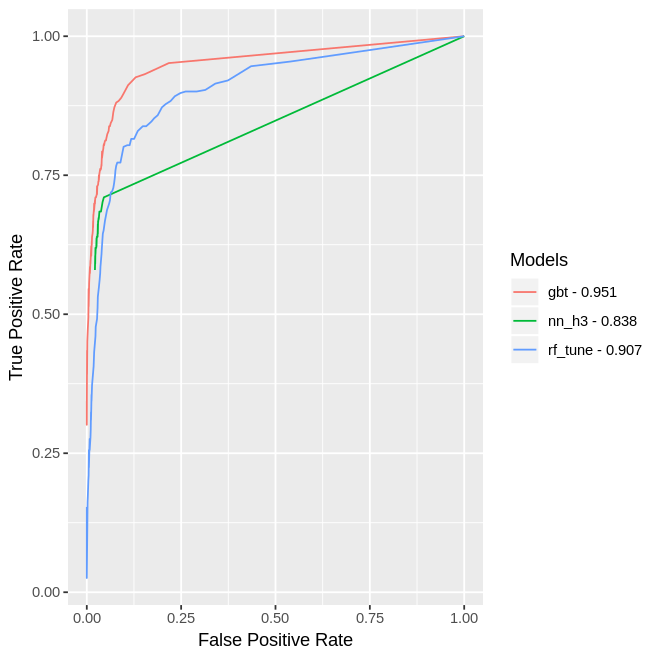

In [99]:
# Add a new column to be used as the ROC curve label
df_assess_roc$Models = paste(df_assess_roc$Model, round(df_assess_roc$'_C_', 3), sep = ' - ')

#Subset the data frame with only three variables 
df_roc = df_assess_roc[c('_FPR_', '_Sensitivity_', 'Models')]
colnames(df_roc) = c("FPR", "Sensitivity", "Models")

# Create the ROC curve
ggplot(data = df_roc, 
   aes(x = FPR, y = Sensitivity, colour = Models)) + 
   geom_line() +
   labs(x = 'False Positive Rate', y = 'True Positive Rate')

# Compare Lift Curves

In [100]:
# Create function to bring assess results to the client
assess_local_lift = function(model){
    castbl.obj = defCasTable(conn, tablename = paste0(model,'_assess'))
    local.tbl = to.casDataFrame(castbl.obj)
    local.tbl$Model = model
    return(local.tbl)
}

# Bring results to client in a loop
df_assess_lift = NULL
for(i in 1:length(models)){
    df_assess_lift = rbind(df_assess_lift,assess_local_lift(models[i]))
}

NOTE: Executing action 'table.columnInfo'.
NOTE: Action 'table.columnInfo' used (Total process time):
NOTE:       real time               0.001197 seconds
NOTE:       cpu time                0.001102 seconds (92.06%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  844.72K (0.00%)
NOTE: Executing action 'table.fetch'.
NOTE: Action 'table.fetch' used (Total process time):
NOTE:       real time               0.002723 seconds
NOTE:       cpu time                0.002670 seconds (98.05%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  1.10M (0.00%)
NOTE: Executing action 'table.columnInfo'.
NOTE: Action 'table.columnInfo' used (Total process time):
NOTE:       real time               0.001329 seconds
NOTE:       cpu time                0.001278 seconds (96.16%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memo

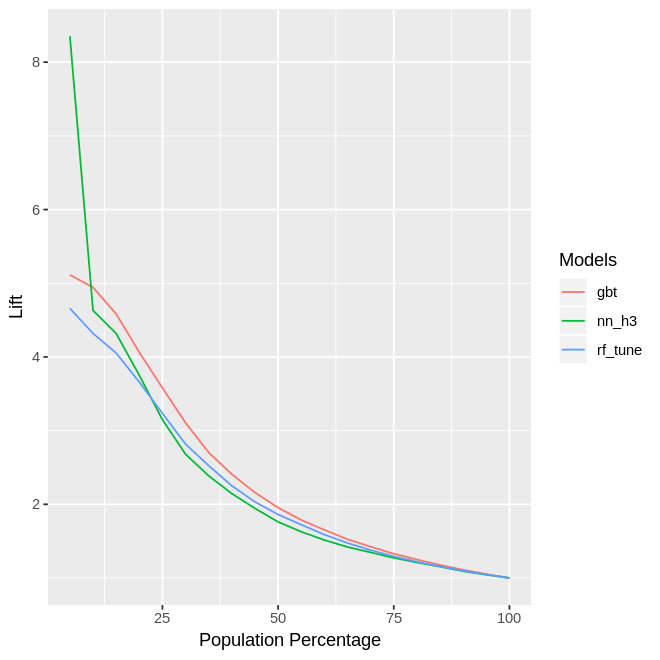

In [101]:
#Subset the data frame with only three variables 
df_lift = df_assess_lift[c('_Depth_', '_CumLift_', 'Model')]
colnames(df_lift) = c("Depth", "CumLift", "Models")

# Create the Lift curve
ggplot(data = df_lift, 
   aes(x = Depth, y = CumLift, colour = Models)) + 
   geom_line() +
   labs(x = 'Population Percentage', y = 'Lift')

# Drop Table from Memory

In [102]:
cas.table.dropTable(conn, table=indata)

NOTE: Executing action 'table.dropTable'.
NOTE: Cloud Analytic Services dropped table hmeq from caslib CASUSER(viyademo01).
NOTE: Action 'table.dropTable' used (Total process time):
NOTE:       real time               0.000825 seconds
NOTE:       cpu time                0.000640 seconds (77.58%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  288.94K (0.00%)


list()

# End the Session

In [103]:
cas.session.endSession(conn)

NOTE: Executing action 'session.endSession'.
NOTE: Action 'session.endSession' used (Total process time):
NOTE:       real time               0.000473 seconds
NOTE:       cpu time                0.000424 seconds (89.64%)
NOTE:       total nodes             1 (16 cores)
NOTE:       total memory            122.80G
NOTE:       memory                  208.78K (0.00%)


list()